In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
synthetic = pd.read_csv("medium_exemplar.csv")

In [3]:
synthetic.head()

,Unnamed: 0,Location,NewHome,FTB,Income,EmpSector,Occ,HouseComp,Education,Exp:Inc,LoanValue,LTV,LoanTerm,Interest,HouseVal,MRTI,Label,age
0,0,2,1,1,76655,2,4,5,4,0.438,157718,0.85,25,0.0535,185551,0.149,0,0
1,1,1,1,1,82307,3,2,2,4,0.473,200820,0.93,25,0.0535,215935,0.177,0,1
2,2,2,2,1,83372,1,4,3,6,0.515,282300,1.00,30,0.0350,282300,0.182,0,0
3,3,6,1,1,106356,3,2,6,5,0.438,154338,1.00,35,0.0350,154338,0.072,0,1
4,4,2,1,2,54021,7,2,1,6,0.495,208120,0.60,20,0.0150,346867,0.223,0,1


In [4]:
synthetic['Label'].value_counts()

0    9923
1    3308
Name: Label, dtype: int64

In [5]:
y = synthetic['Label']
synthetic.pop('Label')
X = synthetic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y,shuffle = True,random_state=69)

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define which columns should be encoded vs scaled
columns_to_encode = ['Location', 'NewHome', 'FTB', 'EmpSector','Occ','HouseComp','Education']
columns_to_scale  = ['Exp:Inc','LoanValue','LTV','LoanTerm','Interest','HouseVal','MRTI']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

# Train
scaled_columns  = scaler.fit_transform(X_train[columns_to_scale]) 
encoded_columns =   ohe.fit_transform(X_train[columns_to_encode])
X_train = np.concatenate([scaled_columns, encoded_columns,X_train['age'].values.reshape(-1,1)], axis=1)

# Test
scaled_columns  = scaler.transform(X_test[columns_to_scale]) 
encoded_columns =   ohe.transform(X_test[columns_to_encode])
X_test = np.concatenate([scaled_columns, encoded_columns,X_test['age'].values.reshape(-1,1)], axis=1)

In [7]:
def df_count_feat_val_match(df1, f1, v1, f2, v2):
    return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])

def underestimation_score(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted outcomes
    - SA     : sensitive attributes
    
    output:
    - us_0: underestimation for S = 0
    - us_1: underestimation for S = 1
    
    """
    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['PEG'] = SA
    us = pd.DataFrame(mydict)   


    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'PEG',0)
    print(P_dash_FX0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'PEG',0)
    print(P_FX0)
    Bias_FX0 = P_dash_FX0/P_FX0
    #print("="*40)
    return Bias_FX0

In [15]:
lr = LogisticRegression(solver = 'lbfgs', max_iter=10000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)
print(underestimation_score(y_train,y_pred,X_train[:,-1]))
print(balanced_accuracy_score(y_train,y_pred))

424
473
0.8964059196617337
0.8511205230849024


In [16]:
def DI_score(y_pred,SA):
    mydict = {}
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',1)
    Bias_FX0 = P_dash_FX0/P_FX0

    if P_FX0 == 0:
        print("Divsion by zero detected!")

    return Bias_FX0

def df_count_feat_val_match(df1, f1, v1, f2, v2):
    return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])

In [17]:
DI_score(y_pred,X_train[:,-1])

0.2362116991643454

In [12]:
y_pred = lr.predict(X_test)
print(underestimation_score(y_test,y_pred,X_test[:,-1]))
print(balanced_accuracy_score(y_test,y_pred))

183
204
0.8970588235294118
0.8561372333915507


In [13]:
DI_score(y_pred,X_test[:,-1])

0.23135271807838179

In [38]:
class Pareto_Simulated_Annealing:

    def __init__(self, random_state=0, verbosity = 0):
        self.random_state = random_state
        self.verbosity = verbosity

    def initialize_weight(self,n_coef):
        w = np.random.normal(0, 1, size=(1, n_coef))
        b = np.random.normal(0, 1)
        return w,b

    def logistic_regression_predict(self,w,b,x,threshold=0.5):
        return np.where((1/(1+np.exp(-(x@w.T+b))))>threshold,1,0).ravel()
    
    def logistic_regression_predict_proba(self,w,b,x,threshold=0.5):
        return (1/(1+np.exp(-(x@w.T+b)))).ravel()

    def underestimation_score(self,y_true,y_pred,SA):
    
        mydict = {}
        mydict['actual'] = y_true
        mydict['predicted'] = y_pred
        mydict['sex'] = SA
        us = pd.DataFrame(mydict)

        P_dash_FX0 = self.df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
        P_FX0 = self.df_count_feat_val_match(us, 'actual', 1, 'sex',0)
        Bias_FX0 = P_dash_FX0/P_FX0
        
        if P_FX0 == 0:
            print("Divsion by zero detected!")
                   
        return Bias_FX0

    def df_count_feat_val_match(self,df1, f1, v1, f2, v2):
        return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])

    def evaluate(self,y_true,y_pred,sa):
        ba = balanced_accuracy_score(y_true,y_pred)
        us_s = self.underestimation_score(y_true,y_pred,sa)
        return ba,us_s

    def identify_pareto(self,scores):
        # Count number of items
        population_size = scores.shape[0]
        # Create a NumPy index for scores on the pareto front (zero indexed)
        population_ids = np.arange(population_size)
        # Create a starting list of items on the Pareto front
        # All items start off as being labelled as on the Parteo front
        pareto_front = np.ones(population_size, dtype=bool)
        # Loop through each item. This will then be compared with all other items
        for i in range(population_size):
            # Loop through all other items
            for j in range(population_size):
                # Check if our 'i' pint is dominated by out 'j' point
                if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                    # j dominates i. Label 'i' point as not on Pareto front
                    pareto_front[i] = 0
                    # Stop further comparisons with 'i' (no more comparisons needed)
                    break
        # Return ids of scenarios on pareto front
        return population_ids[pareto_front]

    def fit(self, x_train, y_train):

        ## initialize PSA parameters
        Set_pareto = []
        pareto_param = []
        T_ba = 0.01
        T_us = 0.1
        beta = 0.1
        alpha = 0.9
    

        ## Randomly generate a set of initial solutions Set_theta
        Set_theta = []
        for i in range (5):
            w,b = self.initialize_weight(x_train.shape[1])
            Set_theta.append((w,b))

        for (w,b) in Set_theta:
            y_hat = self.logistic_regression_predict(w,b,x_train)
            best_ba,best_us = self.evaluate(y_train,y_hat,x_train[:,-1])
            convergence = 0
            while T_ba > 0 and T_us > 0:
                
                N_success = 0
                N_trials = 0
                while N_success < 1000 and N_trials < 10000:

                    ## generate candidate solutions
                    updates = np.zeros(x_train.shape[1]+1)
                    updates[np.random.choice(np.arange(len(updates)))] = np.random.normal(0, 1, 1)
                    w_candidate = w + updates[:x_train.shape[1]] * beta
                    b_candidate = b + updates[-1] * beta
                    y_hat = self.logistic_regression_predict(w_candidate,b_candidate,x_train)
                    candidate_ba,candidate_us = self.evaluate(y_train,y_hat,x_train[:,-1])

                    delta_E_ba = (best_ba - candidate_ba)
                    delta_E_us = (abs(1-best_us) - abs(1-candidate_us))
#                     print(delta_E_ba,delta_E_us)
                    if (delta_E_ba < 0 and delta_E_us > 0):
                        w = w_candidate
                        b = b_candidate
                        best_ba = candidate_ba
                        best_us = candidate_us
                        N_success += 1
                        Set_pareto.append((best_ba,best_us))
                        pareto_param.append((w,b))
                    else:
                        prob_us = abs(delta_E_us) / T_us
                        prob_ba = delta_E_ba/T_ba
                        delta_E = prob_ba + prob_us
                        accept_prob = min(1,np.exp(-delta_E))
                        if accept_prob > np.random.rand():
                            w = w_candidate
                            b = b_candidate
                            best_ba = candidate_ba
                            best_us = candidate_us
                            Set_pareto.append((best_ba,best_us))
                            pareto_param.append((w,b))
                            N_success += 1
                        else:
                            N_trials += 1

                ## Decrease temperatures by Alpha
                T_ba = T_ba * alpha
                T_us = T_us * alpha
                
                convergence += 1

                if self.verbosity != 0:
                    print("Temp_ba: {}, Temp_US: {}".format(T_ba,T_us))
                    print("Best ba  :   {}".format(best_ba))
                    print("Best us_s:   {}".format(best_us))
                    print("Success #:   {}".format(N_success))
                    print("Trials  #:   {}".format(N_trials))
                    print("Coef     :   {}".format(w))
                    print("Intercept:   {}".format(b))
                    print("convergence: {}".format(convergence))
                    print("\n")
            

                # Convergence
                if convergence == 100:
                    print("PSA has converged!")
                    break
        return Set_pareto,pareto_param

        def filter_Pareto(Set_pareto,pareto_param):
            pareto_array = np.array(Set_pareto)
            inverser = lambda t: 1/(abs(1-t)+0.000000001)
            pareto_array[:,1] = [inverser(x) for x in pareto_array[:,1]]
            pareto_index = self.identify_pareto(pareto_array)

            #pareto filtered
            pareto_ba = [Set_pareto[idx][0] for idx in pareto_index]
            pareto_us = [Set_pareto[idx][1] for idx in pareto_index]
            pareto_w = [pareto_param[idx][0] for idx in pareto_index]
            pareto_b = [pareto_param[idx][1] for idx in pareto_index]

            return pareto_ba,pareto_us,pareto_w,pareto_b


In [39]:
psa = Pareto_Simulated_Annealing(verbosity=1)
Set_pareto,pareto_param = psa.fit(X_train,y_train)


Temp_ba: 0.009000000000000001, Temp_US: 0.09000000000000001
Best ba  :   0.6093337122722091
Best us_s:   3.4799154334038054
Success #:   1000
Trials  #:   88
Coef     :   [[-0.63937885 -0.63767712 -0.30544669 -0.59723382  0.75478736 -0.5381674
  -0.86166903  2.04577237 -1.3787445  -1.47887051 -1.53275695  0.66448601
   0.50118315 -1.44018072 -0.11225384  0.78091042  0.25295377 -0.96780252
   1.85505277 -0.08296984 -1.55249703 -1.49194727 -1.00936154  0.34933685
  -0.81926931 -1.35613307 -1.2366058  -1.45222406  2.0194171   0.62283462
  -1.72227058  2.20224751 -0.57071864 -0.55026326 -0.90267795  0.32212667
   1.2650372  -0.48386089  1.87278076 -0.1437454  -2.36894055  0.14208085
  -0.61921636  1.79139827  2.36741919 -2.27585325  1.64782034  1.53978506
  -2.29783643 -0.33244834  1.60918063]]
Intercept:   0.41988745537507377
convergence: 1


Temp_ba: 0.008100000000000001, Temp_US: 0.08100000000000002
Best ba  :   0.6699453171301724
Best us_s:   2.699788583509514
Success #:   1000
Trials 

Temp_ba: 0.003138105960900002, Temp_US: 0.03138105960900001
Best ba  :   0.7968501224192304
Best us_s:   1.2473572938689217
Success #:   1000
Trials  #:   98
Coef     :   [[-4.19894696 -0.80141933 -1.76461749 -2.82493885  2.12661833 -0.23657891
  -1.44831743  2.91096531 -0.99006753 -2.61696855 -1.16069977  1.72357592
   0.69304407 -2.91570557 -0.40472679 -0.40747432  0.88694694 -1.10855892
   1.59566817 -1.40657016 -2.40503855 -1.57298643  0.35147239  2.09493339
  -0.08931398  0.63973657 -2.50999007 -1.14749956  0.96611192  2.00623097
  -1.48710255  3.1993264  -0.55318924 -2.12648291 -0.26247368  0.63197997
  -1.73889766 -2.13427611  2.40083119  0.49276512 -2.17451843 -2.20109119
  -0.79998631  3.16233866  2.82734717 -1.12488072  0.9147864  -0.54247084
  -0.49740406  0.38895207  1.62788147]]
Intercept:   -2.5475091162261148
convergence: 11


Temp_ba: 0.0028242953648100018, Temp_US: 0.028242953648100012
Best ba  :   0.7998015546029569
Best us_s:   1.1923890063424947
Success #:   1000
Tr

Temp_ba: 0.0010941898913151245, Temp_US: 0.010941898913151246
Best ba  :   0.8428504930662271
Best us_s:   1.6109936575052854
Success #:   1000
Trials  #:   249
Coef     :   [[-5.25303355  0.93757002 -2.89616002 -1.79206989  2.8385185  -0.48295033
  -4.07526742  2.9021062  -0.12415061 -3.29757963 -1.52009224  1.42036193
  -1.13267581 -2.21807907 -0.7614219  -0.45557409  1.46133056 -1.46420952
   2.22848202 -2.19325227  0.01465468 -2.860479    2.52930887  4.30281127
   0.9983738   1.47286882 -0.2472455   1.66284844  0.98480308  2.14309112
  -1.34805668  2.00602298 -1.08220557 -2.03768948 -2.04876409 -1.46365153
  -2.32007955 -1.65768209  0.26367966  1.76934641  0.14286672 -2.3678929
  -0.19228439  4.9483185   1.04405081 -2.19827203 -1.32357816 -1.54755226
   1.05076184 -0.74781599 -0.02484442]]
Intercept:   -3.1991018930502593
convergence: 21


Temp_ba: 0.0009847709021836122, Temp_US: 0.009847709021836121
Best ba  :   0.845370581698123
Best us_s:   1.5243128964059196
Success #:   1000
T

Temp_ba: 0.00038152042447694626, Temp_US: 0.0038152042447694634
Best ba  :   0.8739495484760873
Best us_s:   1.276955602536998
Success #:   1000
Trials  #:   524
Coef     :   [[-5.35456603  0.53997608 -2.58687751 -1.17713833  2.7594307   0.44058142
  -5.57099077  3.46164966  0.43823806 -2.1652649  -2.75759362  1.27093573
  -2.50854819 -3.38141815 -1.81230987 -1.53482111  1.57958666 -1.60016165
  -1.85119961 -1.52553288 -3.66996357 -2.3428499   1.50958966  4.52987912
   0.72590991  2.24540108  0.87477718 -0.19878655 -0.18300364  0.53470747
  -0.25806365  1.69584649  0.15837402 -3.16356942 -2.48058692 -5.65778582
  -4.45641915 -2.52485053 -1.61287169  2.78963373  2.32740323 -2.15395092
  -0.74723131  3.25186259 -0.32172031 -2.40991156 -1.83260649 -0.73747986
   1.19738474 -0.21412479  2.60598007]]
Intercept:   -4.448078772720762
convergence: 31


Temp_ba: 0.00034336838202925164, Temp_US: 0.003433683820292517
Best ba  :   0.8739491442469802
Best us_s:   1.266384778012685
Success #:   1000

Temp_ba: 0.00014780882941434616, Temp_US: 0.0014780882941434613
Best ba  :   0.8824435214201004
Best us_s:   1.2325581395348837
Success #:   1000
Trials  #:   1287
Coef     :   [[-5.60486162  0.70987698 -2.6478693  -1.06903522  3.0565419   0.61162773
  -5.8967158   3.38426102  0.0256577   0.06516123 -1.41394111 -0.38423866
  -3.11777897 -3.7152015  -2.21426925 -1.28887902  1.28582243  0.36831903
  -1.51620363 -1.89835791 -4.01122648 -2.29199352  1.2271592   4.63104436
   1.52498064  4.0415417   1.32994286  1.28109383 -2.15390129  0.2257307
  -1.09386385  1.63584243  0.07386983 -3.06884557 -1.63193755 -8.56145427
  -4.98180914 -2.50173733 -4.09154299  3.24331859  2.09281386 -2.09850002
  -0.85432361  3.68490248 -1.89388618 -2.33607616 -2.0101417  -1.18249009
   1.1202677   0.50579269  3.02205548]]
Intercept:   -4.618982305111102
convergence: 40


Temp_ba: 0.00013302794647291155, Temp_US: 0.0013302794647291152
Best ba  :   0.8820835398529476
Best us_s:   1.2241014799154335
Success #:   1

Temp_ba: 5.153775207320124e-05, Temp_US: 0.0005153775207320121
Best ba  :   0.8889943650462468
Best us_s:   1.2135306553911205
Success #:   1000
Trials  #:   1955
Coef     :   [[-5.68843175  0.82974154 -2.61180857 -1.07337658  3.03451073  0.51571169
  -6.09306586  3.39280632  0.45644305  0.73316246 -2.03914827 -3.08633691
  -2.89978183 -3.71072143 -2.22101804 -1.20475898  1.20080925  1.03341492
  -2.34335619 -2.04239985 -3.84459149 -2.67315604  1.39447246  4.42734307
   0.90924211  3.75770269  1.73408139  0.97372671 -4.2096728   0.24187407
  -1.73323824  1.49970276 -0.05734986 -2.42067704 -3.46565309 -9.33277598
  -5.13880087 -2.39238883 -3.83826123  3.26025687  2.12156733 -2.09429866
  -1.07160491 -3.61026422 -2.16011218 -2.48748771 -1.7289354  -1.03381969
   1.08856731  0.74997874  3.22127045]]
Intercept:   -4.6534048795137295
convergence: 50


Temp_ba: 4.6383976865881114e-05, Temp_US: 0.00046383976865881093
Best ba  :   0.8899301554292012
Best us_s:   1.2135306553911205
Success #:  

Temp_ba: 1.797010299914435e-05, Temp_US: 0.00017970102999144343
Best ba  :   0.890362089777419
Best us_s:   1.2093023255813953
Success #:   1000
Trials  #:   3298
Coef     :   [[-5.68415679  0.83767622 -2.63322488 -1.0432513   3.01631688  0.5232596
  -6.12353571  3.43125545  0.56061435  0.76451336 -1.15975843 -3.3216734
  -2.9487208  -3.65469537 -2.24530724 -1.12504963  1.22568285  0.5100689
  -2.57844373 -2.08902085 -4.33510413 -2.88556848  1.16065002  4.28190144
   0.72015922  3.58213467  1.65239721  0.8146967  -4.27836844  0.13355217
  -1.82846998  1.46210188 -0.0653074  -2.6381974  -3.2869923  -8.92809544
  -5.03016521 -2.45135135 -3.7000644   3.24459832  2.06033013 -2.05261964
  -1.06993872 -3.65320314 -2.08437877 -2.36686221 -1.65232679 -0.95503709
   1.18473159  0.8702137   3.23936665]]
Intercept:   -4.681052087271747
convergence: 60


Temp_ba: 1.6173092699229914e-05, Temp_US: 0.0001617309269922991
Best ba  :   0.8902901059018071
Best us_s:   1.2093023255813953
Success #:   1000

Temp_ba: 6.265787482177985e-06, Temp_US: 6.265787482177983e-05
Best ba  :   0.8905060575286428
Best us_s:   1.2093023255813953
Success #:   1000
Trials  #:   4008
Coef     :   [[-5.71397168  0.83628302 -2.62851575 -1.05817068  3.00882661  0.5545245
  -6.11921736  3.37883512  0.59133447  0.8564999  -1.14572412 -3.45757349
  -2.94106025 -3.68466791 -2.24448975 -1.14008802  1.21961072  0.4753086
  -2.4302702  -2.02054816 -4.25981158 -2.70106201  1.28603353  4.38233725
   0.84370358  3.56758916  1.62659354  0.88250001 -4.242353    0.21613538
  -1.76929162  1.46070805 -0.05550643 -2.6879713  -3.2232787  -8.78952008
  -5.07861152 -2.54326035 -3.90604452  3.20275924  1.9150877  -2.15953268
  -1.08170911 -3.77276896 -2.13685518 -2.32097905 -1.602623   -0.90884507
   1.20447505  0.97891463  3.23286261]]
Intercept:   -4.679417370042894
convergence: 70


Temp_ba: 5.639208733960187e-06, Temp_US: 5.639208733960185e-05
Best ba  :   0.8905060575286428
Best us_s:   1.2093023255813953
Success #:   1000

Temp_ba: 2.1847450052839273e-06, Temp_US: 2.1847450052839264e-05
Best ba  :   0.8907220402500251
Best us_s:   1.2093023255813953
Success #:   1000
Trials  #:   5883
Coef     :   [[-5.7183427   0.84029255 -2.62461509 -1.05077296  3.00115333  0.54257904
  -6.11067893  3.35448389  0.6217435   0.68560758 -1.20891444 -3.51259215
  -2.98149942 -3.71931034 -2.27027913 -1.17379032  1.23235573  0.69227079
  -2.43420102 -2.08141468 -4.17300844 -2.7295938   1.35212469  4.46766242
   0.83270434  3.53181811  1.64483345  0.89180481 -4.20575303  0.13231119
  -1.53628651  1.48392457  0.01870694 -2.46941189 -3.30387007 -8.99342724
  -5.06538938 -2.55334807 -4.02402266  3.17126042  1.80103207 -2.14068408
  -1.07842064 -3.71508738 -2.13109463 -2.35028808 -1.60925012 -0.93664756
   1.2406345   0.80098429  3.23869529]]
Intercept:   -4.682008277843481
convergence: 80


Temp_ba: 1.9662705047555346e-06, Temp_US: 1.9662705047555338e-05
Best ba  :   0.8907940241256369
Best us_s:   1.2093023255813953
Success #: 

Temp_ba: 8.46414978287407e-07, Temp_US: 8.464149782874067e-06
Best ba  :   0.8907940241256369
Best us_s:   1.2093023255813953
Success #:   1000
Trials  #:   5910
Coef     :   [[-5.71070805  0.84498319 -2.62921934 -1.04470163  3.00171093  0.54517561
  -6.11775813  3.32428865  0.57010736  0.61505394 -1.27857938 -3.61700439
  -3.00647557 -3.68247041 -2.27379331 -1.16678954  1.21405368  0.76410365
  -2.36509741 -1.95459637 -4.0901019  -2.73392845  1.42604967  4.49442077
   0.93959678  3.62149394  1.6911272   0.97368361 -4.14529453  0.23102976
  -1.5054301   1.49543776  0.01829059 -2.40312026 -3.29863794 -9.01054949
  -5.06827966 -2.60277474 -3.997656    3.14791136  1.81781356 -2.16622957
  -1.10413894 -3.68263222 -2.16949886 -2.32573285 -1.5884211  -0.92836312
   1.23778517  0.91938163  3.22061533]]
Intercept:   -4.686775858416808
convergence: 89


Temp_ba: 7.617734804586663e-07, Temp_US: 7.6177348045866605e-06
Best ba  :   0.8907940241256369
Best us_s:   1.2093023255813953
Success #:   10

Temp_ba: 2.951266543065285e-07, Temp_US: 2.9512665430652833e-06
Best ba  :   0.8907940241256369
Best us_s:   1.2093023255813953
Success #:   1000
Trials  #:   5728
Coef     :   [[-5.70827662  0.84501157 -2.62591626 -1.04002919  2.9879782   0.54280464
  -6.10103987  3.29328711  0.57659796  0.63773952 -1.22897009 -3.59210719
  -3.01873088 -3.71015505 -2.27691148 -1.17128978  1.20766757  0.79215481
  -2.37011289 -1.96574216 -4.09508152 -2.6273338   1.41339075  4.49421204
   0.94264052  3.64534252  1.66154547  0.95121403 -4.12521289  0.23475178
  -1.48485035  1.53027877  0.03732568 -2.4813278  -3.36013973 -8.89460664
  -4.99889634 -2.59374223 -3.86500104  3.14243512  1.78126037 -2.17162327
  -1.08610003 -3.72072814 -2.08482679 -2.35145802 -1.58218496 -0.93536224
   1.22741899  0.79466818  3.21824432]]
Intercept:   -4.68102699896137
convergence: 99


Temp_ba: 2.6561398887587566e-07, Temp_US: 2.656139888758755e-06
Best ba  :   0.8907940241256369
Best us_s:   1.2093023255813953
Success #:   1

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

Temp_ba: 2.390525899882881e-07, Temp_US: 2.3905258998828797e-06
Best ba  :   0.7792125803560823
Best us_s:   1.6469344608879493
Success #:   1000
Trials  #:   2333
Coef     :   [[-0.00906064  0.01938783  0.45495327 -1.0097298   0.7931061   1.30163369
  -2.6470009  -1.79534787 -0.22212988 -2.0118008  -1.25952271 -1.6709178
  -1.2365309   0.24278599  2.22417097 -2.71915176  1.26346933 -0.01304053
  -4.23638917 -1.50320633 -1.35775256 -0.16333879 -1.0526878   1.46203451
  -1.08679709  0.50380231  1.25649049 -0.2580858  -1.59585631 -1.25010021
  -1.68136995  1.15137559  0.29026976 -1.20817903 -1.85944425 -1.66748139
  -0.83482445 -1.11238217 -3.20889702 -0.41522865  0.59286792  0.23829257
  -0.68686835 -1.35436033 -1.38023751 -0.91350501 -0.62390985 -0.1500901
  -0.38839145  0.28097888 -0.45222562]]
Intercept:   -0.13612055636962478
convergence: 1




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.151473309894593e-07, Temp_US: 2.151473309894592e-06
Best ba  :   0.7834593491662619
Best us_s:   1.6109936575052854
Success #:   971
Trials  #:   10000
Coef     :   [[-0.01378539  0.01850224  0.45683069 -1.00900857  0.7931061   1.30089661
  -2.66046968 -1.79441431 -0.28950223 -1.98686946 -1.40480829 -1.87996997
  -1.24490383  0.2366498   2.22193974 -2.62361101  1.26060812 -0.01965751
  -4.17979557 -1.65281961 -1.53452393 -0.19404329 -1.03209697  1.45085757
  -1.0718666   0.47930824  1.14503843 -0.23913992 -1.77972041 -1.22533878
  -1.75777448  1.16381969  0.28264565 -1.04956775 -2.00563408 -1.66682202
  -0.93481401 -1.11356585 -3.28012796 -0.41614103  0.532361    0.23152577
  -0.69060169 -1.41438883 -1.37119592 -1.45430283 -0.55349198 -0.14407238
  -0.38780986  0.18333494 -0.45467723]]
Intercept:   -0.13612055636962478
convergence: 2


Temp_ba: 1.936325978905134e-07, Temp_US: 1.9363259789051326e-06
Best ba  :   0.7836753007930976
Best us_s:   1.6109936575052854
Success #:   

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.7426933810146205e-07, Temp_US: 1.7426933810146194e-06
Best ba  :   0.7843230934845109
Best us_s:   1.6067653276955602
Success #:   619
Trials  #:   10000
Coef     :   [[-0.01538786  0.01884077  0.45655296 -1.00877646  0.79662869  1.30151612
  -2.66162691 -1.79585364 -0.28448925 -1.97721575 -1.4048466  -1.87030696
  -1.25136609  0.23388191  2.22204515 -2.65962226  1.26316984  0.00659909
  -4.17109223 -1.64868104 -1.54661197 -0.1937888  -1.03367168  1.49562269
  -1.05891531  0.37429116  1.15048205 -0.24536238 -1.78026311 -1.2201557
  -1.74340282  1.1616378   0.29346502 -1.0561705  -1.90411878 -1.67608195
  -0.92384169 -1.11772095 -3.32358328 -0.41755946  0.54392874  0.22511515
  -0.71319591 -1.79163237 -1.36971139 -1.46435829 -0.56461088 -0.1406888
  -0.39024971  0.18606874 -0.45570498]]
Intercept:   -0.13612055636962478
convergence: 4


Temp_ba: 1.5684240429131584e-07, Temp_US: 1.5684240429131575e-06
Best ba  :   0.7845389829222531
Best us_s:   1.6004228329809724
Success #:  

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 8.335248417898118e-08, Temp_US: 8.335248417898112e-07
Best ba  :   0.7851147295489611
Best us_s:   1.587737843551797
Success #:   361
Trials  #:   10000
Coef     :   [[-0.0172689   0.01769308  0.45616563 -1.00858589  0.79662869  1.30151612
  -2.66060348 -1.79767104 -0.30395674 -1.97274292 -1.43087534 -1.84733138
  -1.26308569  0.233172    2.22008413 -2.60495407  1.26316984 -0.0079483
  -4.14023272 -1.64196779 -1.56529467 -0.19324081 -1.03694694  1.43672214
  -1.09610509  0.36511264  1.14375836 -0.25688686 -2.13636878 -1.33221098
  -1.73446313  1.16321928  0.27413652 -1.019017   -1.90978163 -1.65808335
  -0.93091586 -1.11957507 -3.29553813 -0.41658682  0.55478272  0.22731825
  -0.70638095 -1.79628061 -1.36381637 -1.45112978 -0.56115285 -0.1449207
  -0.39582     0.19953332 -0.45384307]]
Intercept:   -0.13584919985249255
convergence: 11


Temp_ba: 7.501723576108307e-08, Temp_US: 7.501723576108301e-07
Best ba  :   0.7851147295489611
Best us_s:   1.587737843551797
Success #:   421


<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 6.076396096647729e-08, Temp_US: 6.076396096647724e-07
Best ba  :   0.7854745867379271
Best us_s:   1.587737843551797
Success #:   494
Trials  #:   10000
Coef     :   [[-0.0172689   0.0181923   0.45366728 -1.00858589  0.7964207   1.30177208
  -2.65985724 -1.79783644 -0.30336755 -1.97074964 -1.48085973 -1.85806805
  -1.26433904  0.23333289  2.22008413 -2.59401372  1.26316984 -0.01802167
  -4.18712307 -1.64653921 -1.59737461 -0.19195568 -1.03600606  1.42564539
  -1.09532137  0.3741091   1.13851674 -0.25414611 -2.13708407 -1.33316732
  -1.71593424  1.16403118  0.27614281 -1.02069855 -1.90380647 -1.65107913
  -0.93173189 -1.11282312 -3.17774789 -0.41985813  0.54626133  0.22615824
  -0.71344444 -2.41768457 -1.36173375 -1.45272954 -0.56106589 -0.15059184
  -0.39582     0.23331292 -0.45308657]]
Intercept:   -0.13606189383269846
convergence: 14




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 5.468756486982956e-08, Temp_US: 5.468756486982952e-07
Best ba  :   0.7855465706135389
Best us_s:   1.587737843551797
Success #:   569
Trials  #:   10000
Coef     :   [[-1.72689015e-02  1.81923030e-02  4.53881119e-01 -1.00858589e+00
   7.96420695e-01  1.30177208e+00 -2.65985724e+00 -1.79783644e+00
  -2.92451667e-01 -1.97019191e+00 -1.47684092e+00 -1.85767120e+00
  -1.26169962e+00  2.33748849e-01  2.22032875e+00 -2.60136616e+00
   1.26375749e+00 -3.64549384e-03 -4.20284117e+00 -1.64781802e+00
  -1.61989835e+00 -1.88273739e-01 -1.03600606e+00  1.43495347e+00
  -1.09384545e+00  3.73160201e-01  1.12760924e+00 -2.54204426e-01
  -2.15464340e+00 -1.33355384e+00 -1.74942399e+00  1.16344767e+00
   2.79547434e-01 -9.97489154e-01 -1.91647185e+00 -1.66032299e+00
  -9.26872884e-01 -1.11242622e+00 -3.21612904e+00 -4.19951909e-01
   5.37342084e-01  2.23450427e-01 -7.15868404e-01 -2.40656755e+00
  -1.36229121e+00 -1.45841612e+00 -5.59426939e-01 -1.51099689e-01
  -3.95820000e-01  2.51445926e-01

Temp_ba: 1.9068374811679737e-08, Temp_US: 1.9068374811679722e-07
Best ba  :   0.7855465706135389
Best us_s:   1.587737843551797
Success #:   519
Trials  #:   10000
Coef     :   [[-0.01775285  0.01647296  0.45308975 -1.0084314   0.79695184  1.30341492
  -2.6611925  -1.79603975 -0.30071383 -1.97518694 -1.47974793 -1.85586307
  -1.26084175  0.23569765  2.22068793 -2.59726323  1.26379738  0.0124858
  -4.20792806 -1.64517434 -1.56978032 -0.18716277 -1.03216649  1.43884826
  -1.0943726   0.37775972  1.14508441 -0.25517805 -2.14410021 -1.33387575
  -1.77326302  1.16108135  0.26542342 -1.04323056 -1.94222229 -1.68545967
  -0.94015462 -1.11964118 -3.26058912 -0.42293707  0.55277518  0.22696005
  -0.71317367 -2.39730941 -1.36485554 -1.45639222 -0.56023831 -0.15263167
  -0.39196049  0.24552554 -0.45179806]]
Intercept:   -0.1362997550726837
convergence: 25


Temp_ba: 1.7161537330511763e-08, Temp_US: 1.716153733051175e-07
Best ba  :   0.7855465706135389
Best us_s:   1.587737843551797
Success #:   5

Temp_ba: 6.648731184578623e-09, Temp_US: 6.648731184578619e-08
Best ba  :   0.7855465706135389
Best us_s:   1.587737843551797
Success #:   626
Trials  #:   10000
Coef     :   [[-0.01934574  0.01603586  0.45282577 -1.0103643   0.79728644  1.3024058
  -2.66310032 -1.80156036 -0.31817814 -1.97898884 -1.4911232  -1.86197723
  -1.26575935  0.23657722  2.22579948 -2.58093357  1.26343856 -0.04002476
  -4.197452   -1.6364218  -1.57321304 -0.19126954 -1.03138183  1.42816824
  -1.08930685  0.37666037  1.14590309 -0.24708566 -2.12327842 -1.33387275
  -1.71901157  1.15836336  0.27329028 -1.02894883 -1.9128116  -1.63060435
  -0.94229618 -1.12391888 -3.2461286  -0.42016448  0.53910466  0.22433332
  -0.71051166 -2.42908938 -1.37375713 -1.45543698 -0.55844123 -0.14790851
  -0.39154589  0.23405883 -0.45109034]]
Intercept:   -0.13623321989879675
convergence: 35


Temp_ba: 5.983858066120761e-09, Temp_US: 5.983858066120757e-08
Best ba  :   0.7855465706135389
Best us_s:   1.587737843551797
Success #:   573

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 4.362232530202035e-09, Temp_US: 4.362232530202032e-08
Best ba  :   0.7857625533349213
Best us_s:   1.587737843551797
Success #:   618
Trials  #:   10000
Coef     :   [[-0.02357722  0.01471499  0.45175485 -1.01049574  0.79728107  1.30107933
  -2.66012344 -1.79722858 -0.30765231 -1.98104391 -1.4948606  -1.84786802
  -1.2664031   0.23657722  2.22232573 -2.6000999   1.26404774 -0.02352009
  -4.13736374 -1.64024374 -1.55156618 -0.18838644 -1.03099875  1.43949486
  -1.08684296  0.3780925   1.14669573 -0.24558075 -2.15214719 -1.33416909
  -1.74779638  1.15840163  0.27102971 -1.00754493 -1.92097478 -1.65959872
  -0.93992148 -1.12519198 -3.14763871 -0.42007306  0.55726376  0.22184936
  -0.70986652 -2.41463705 -1.37195613 -1.45863287 -0.56791511 -0.14963578
  -0.3917605   0.25597839 -0.45109034]]
Intercept:   -0.13653175463264886
convergence: 39


Temp_ba: 3.926009277181832e-09, Temp_US: 3.9260092771818286e-08
Best ba  :   0.7857625533349213
Best us_s:   1.587737843551797
Success #:   5

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.6900182599825802e-09, Temp_US: 1.6900182599825784e-08
Best ba  :   0.7859065210861449
Best us_s:   1.5856236786469344
Success #:   501
Trials  #:   10000
Coef     :   [[-0.02503896  0.01440411  0.45025765 -1.011221    0.79599311  1.29919208
  -2.66027916 -1.79586687 -0.30098878 -1.99144848 -1.49919176 -1.86908915
  -1.27426187  0.23760859  2.21957129 -2.61580066  1.26192182 -0.00651125
  -4.26639626 -1.63654571 -1.54389513 -0.16390622 -1.02061485  1.45981875
  -1.0775337   0.39845871  1.16647629 -0.24336927 -2.12342291 -1.32218154
  -1.77837775  1.15866775  0.25128901 -1.03527478 -1.90633198 -1.66438294
  -0.95232571 -1.12303836 -3.14343201 -0.42166717  0.55730008  0.2236853
  -0.71128058 -2.43268042 -1.36643902 -1.46246635 -0.57092092 -0.14813447
  -0.38824592  0.31260207 -0.44859171]]
Intercept:   -0.1394589941869241
convergence: 48


Temp_ba: 1.5210164339843222e-09, Temp_US: 1.5210164339843205e-08
Best ba  :   0.7859065210861449
Best us_s:   1.5856236786469344
Success #: 

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 8.083304946930622e-10, Temp_US: 8.083304946930615e-09
Best ba  :   0.7860503644591819
Best us_s:   1.5708245243128964
Success #:   570
Trials  #:   10000
Coef     :   [[-2.37580564e-02  1.49208470e-02  4.49069716e-01 -1.01188143e+00
   7.96949848e-01  1.29973314e+00 -2.66385148e+00 -1.79469233e+00
  -3.06608930e-01 -1.99025743e+00 -1.50041950e+00 -1.86433391e+00
  -1.28200349e+00  2.37558532e-01  2.21382977e+00 -2.61389001e+00
   1.26180543e+00 -8.69310274e-05 -4.13461997e+00 -1.63722877e+00
  -1.55956596e+00 -1.84206013e-01 -1.02719008e+00  1.46784873e+00
  -1.07612663e+00  3.91938970e-01  1.16303710e+00 -2.45490802e-01
  -2.13112656e+00 -1.33651418e+00 -1.77653430e+00  1.15741463e+00
   2.48042714e-01 -1.03261945e+00 -1.92853094e+00 -1.66814257e+00
  -9.50329626e-01 -1.12410838e+00 -3.12506428e+00 -4.18521708e-01
   5.70286715e-01  2.24764508e-01 -6.94934564e-01 -2.41440548e+00
  -1.36657321e+00 -1.59023653e+00 -5.76709255e-01 -1.48769846e-01
  -3.87632929e-01  2.52317606e-0

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 7.27497445223756e-10, Temp_US: 7.274974452237553e-09
Best ba  :   0.7861223483347937
Best us_s:   1.5708245243128964
Success #:   539
Trials  #:   10000
Coef     :   [[-2.37580564e-02  1.49208470e-02  4.49069716e-01 -1.01188143e+00
   7.96681247e-01  1.29973314e+00 -2.66385148e+00 -1.79409593e+00
  -3.06608930e-01 -1.99311308e+00 -1.47846008e+00 -1.87349792e+00
  -1.28200349e+00  2.37610312e-01  2.21382977e+00 -2.61393539e+00
   1.26186452e+00  1.57875592e-03 -4.20244585e+00 -1.63346288e+00
  -1.53618701e+00 -2.20237492e-01 -1.02387264e+00  1.46494274e+00
  -1.08047861e+00  3.89936448e-01  1.16081027e+00 -2.46895525e-01
  -2.16829910e+00 -1.33320659e+00 -1.76829796e+00  1.15741463e+00
   2.52720802e-01 -1.05618365e+00 -1.92542266e+00 -1.66950716e+00
  -9.49178550e-01 -1.12614514e+00 -3.12770960e+00 -4.19895853e-01
   5.72404721e-01  2.24764508e-01 -6.92344929e-01 -2.42070682e+00
  -1.36925881e+00 -1.59671807e+00 -5.79215580e-01 -1.48769846e-01
  -3.87897718e-01  2.52282811e-01

Temp_ba: 2.5366267437735453e-10, Temp_US: 2.5366267437735426e-09
Best ba  :   0.7861223483347937
Best us_s:   1.5708245243128964
Success #:   532
Trials  #:   10000
Coef     :   [[-0.02130266  0.0148035   0.44934837 -1.00990617  0.79698448  1.30070156
  -2.66595984 -1.79356227 -0.30327702 -2.00246456 -1.4107704  -1.87585049
  -1.27830177  0.23500046  2.2167675  -2.61660464  1.26276824  0.04598001
  -4.16403684 -1.63930175 -1.55101661 -0.21237213 -1.01974277  1.46084464
  -1.07702066  0.38085827  1.16145689 -0.25265586 -2.15144948 -1.3219703
  -1.77577305  1.1618499   0.25659216 -1.05143545 -1.90136315 -1.7270052
  -0.93252048 -1.13555631 -3.13830496 -0.4187544   0.56246614  0.22259434
  -0.71120232 -2.3596003  -1.37230151 -1.59800396 -0.58681108 -0.14152706
  -0.39034609  0.19330638 -0.44648162]]
Intercept:   -0.138056188879259
convergence: 66


Temp_ba: 2.2829640693961908e-10, Temp_US: 2.2829640693961886e-09
Best ba  :   0.7861223483347937
Best us_s:   1.5708245243128964
Success #:   

Temp_ba: 8.844670561349026e-11, Temp_US: 8.844670561349014e-10
Best ba  :   0.7861223483347937
Best us_s:   1.5708245243128964
Success #:   581
Trials  #:   10000
Coef     :   [[-0.02340719  0.0127465   0.44874562 -1.01116786  0.79747795  1.30115467
  -2.66486515 -1.7984852  -0.31307024 -2.00316586 -1.46288418 -1.88468117
  -1.29266682  0.24065681  2.22150463 -2.61054307  1.26349037 -0.02001647
  -4.11740113 -1.63583746 -1.54223502 -0.21882262 -1.02312501  1.46858553
  -1.08650662  0.38395913  1.16376655 -0.25182268 -2.16650061 -1.33251779
  -1.76626719  1.15671858  0.247466   -1.03845326 -1.91903849 -1.64443237
  -0.93504887 -1.13751818 -3.14349881 -0.41445345  0.58705611  0.21745108
  -0.69610012 -2.39243408 -1.37277055 -1.58973153 -0.58088949 -0.14139623
  -0.39131129  0.22688    -0.44508917]]
Intercept:   -0.1359512706688322
convergence: 76


Temp_ba: 7.960203505214123e-11, Temp_US: 7.960203505214112e-10
Best ba  :   0.7861223483347937
Best us_s:   1.5708245243128964
Success #:   5

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 6.447764839223441e-11, Temp_US: 6.447764839223432e-10
Best ba  :   0.7862663160860175
Best us_s:   1.5708245243128964
Success #:   579
Trials  #:   10000
Coef     :   [[-0.02452164  0.01323717  0.44874562 -1.01146767  0.79816176  1.30193769
  -2.6644183  -1.80079976 -0.29966758 -2.00654604 -1.47109089 -1.86251533
  -1.28923136  0.24041175  2.22132626 -2.61037102  1.26349037 -0.02082222
  -4.21104909 -1.64784608 -1.53638923 -0.2191556  -1.01845988  1.46424664
  -1.08690103  0.37826188  1.14761901 -0.26173236 -2.1338618  -1.32989635
  -1.77052212  1.15643211  0.24015978 -1.00340772 -1.92308529 -1.652359
  -0.93966302 -1.12195399 -3.11608018 -0.41516513  0.57234206  0.22130276
  -0.70375842 -2.37654953 -1.36443813 -1.6011746  -0.58096694 -0.14691008
  -0.39128824  0.25142656 -0.44402582]]
Intercept:   -0.13498002830655656
convergence: 79


Temp_ba: 5.802988355301097e-11, Temp_US: 5.802988355301089e-10
Best ba  :   0.7862663160860175
Best us_s:   1.5708245243128964
Success #:   58

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 4.7004205677938887e-11, Temp_US: 4.700420567793882e-10
Best ba  :   0.7863382999616293
Best us_s:   1.5708245243128964
Success #:   592
Trials  #:   10000
Coef     :   [[-0.02714923  0.01369948  0.44906989 -1.01154106  0.79818759  1.30232394
  -2.66489262 -1.80355495 -0.29754811 -2.00912486 -1.44367671 -1.85341899
  -1.29479578  0.23797129  2.22091784 -2.61434733  1.26349037  0.06198805
  -4.19667319 -1.64765941 -1.52357435 -0.22934454 -1.02157082  1.45835969
  -1.08805284  0.39030076  1.14314826 -0.27071672 -2.17402706 -1.3310733
  -1.77589401  1.15769077  0.23721871 -1.02904306 -1.93319341 -1.74311694
  -0.93752631 -1.11966709 -3.12719511 -0.40914245  0.58278943  0.22112203
  -0.71406168 -2.40874451 -1.35869565 -1.59919849 -0.57942074 -0.14538616
  -0.39257258  0.2418522  -0.44418732]]
Intercept:   -0.135255381612901
convergence: 82


Temp_ba: 4.2303785110145e-11, Temp_US: 4.230378511014494e-10
Best ba  :   0.7863382999616293
Best us_s:   1.5708245243128964
Success #:   593


<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 3.80734065991305e-11, Temp_US: 3.8073406599130447e-10
Best ba  :   0.7864102838372412
Best us_s:   1.5708245243128964
Success #:   627
Trials  #:   10000
Coef     :   [[-0.02783747  0.01375886  0.44819242 -1.01143521  0.79867005  1.30088483
  -2.66610341 -1.80406512 -0.29572315 -2.00702974 -1.45892899 -1.85866701
  -1.29205108  0.23642128  2.22032631 -2.61761374  1.26365706  0.06617728
  -4.15788134 -1.63971624 -1.56209988 -0.23461724 -1.02218183  1.46637591
  -1.0806589   0.38573504  1.13490231 -0.26756878 -2.17103915 -1.33391861
  -1.77883325  1.15712963  0.23308662 -1.04476192 -1.92507941 -1.75954606
  -0.93859594 -1.11862995 -3.11391857 -0.40938704  0.59181829  0.22230046
  -0.71419151 -2.4410384  -1.35967077 -1.58803864 -0.57484676 -0.1451671
  -0.39096751  0.24038494 -0.44428132]]
Intercept:   -0.135255381612901
convergence: 84


Temp_ba: 3.426606593921745e-11, Temp_US: 3.42660659392174e-10
Best ba  :   0.7864102838372412
Best us_s:   1.5708245243128964
Success #:   572


<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.6389353113923297e-11, Temp_US: 1.6389353113923274e-10
Best ba  :   0.7865542204939182
Best us_s:   1.5687103594080338
Success #:   667
Trials  #:   10000
Coef     :   [[-0.02840736  0.01306288  0.44684379 -1.01111232  0.79930925  1.30124125
  -2.66606121 -1.80047913 -0.28107148 -2.0088991  -1.45360698 -1.85947979
  -1.29580266  0.2364741   2.21796793 -2.62152062  1.2651643  -0.02992702
  -4.21665807 -1.64119932 -1.52641454 -0.22168482 -1.02092641  1.47306985
  -1.05960926  0.38252417  1.1450743  -0.26684369 -2.16990955 -1.33271229
  -1.93272889  1.15832744  0.23350498 -1.01892205 -1.91410985 -1.63992838
  -0.9450944  -1.12301087 -3.11791724 -0.40843348  0.56997155  0.22593971
  -0.71098381 -2.41442716 -1.364531   -1.60218243 -0.58204878 -0.15100158
  -0.39175986  0.28383972 -0.44395087]]
Intercept:   -0.13552788035062066
convergence: 92


Temp_ba: 1.475041780253097e-11, Temp_US: 1.4750417802530948e-10
Best ba  :   0.7865542204939182
Best us_s:   1.5687103594080338
Success #:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 9.677749120240569e-12, Temp_US: 9.677749120240554e-11
Best ba  :   0.78662620436953
Best us_s:   1.5687103594080338
Success #:   569
Trials  #:   10000
Coef     :   [[-0.03028698  0.00999782  0.44777469 -1.01069359  0.79930925  1.3023744
  -2.6653746  -1.80415015 -0.28225665 -2.01125004 -1.44376751 -1.87928084
  -1.29640687  0.23809255  2.21985306 -2.64342912  1.26527763  0.04495036
  -4.20084731 -1.63292437 -1.54205728 -0.21553635 -1.01671503  1.48053334
  -1.05676777  0.39402312  1.17054163 -0.25794207 -2.17798758 -1.3286151
  -1.9323008   1.15928293  0.23195816 -1.09202917 -1.92570018 -1.72217318
  -0.95269355 -1.12865375 -3.14111486 -0.41438023  0.58656995  0.22644661
  -0.71471047 -2.3889895  -1.36714053 -1.60684965 -0.57799538 -0.14791779
  -0.39226514  0.23208259 -0.44270118]]
Intercept:   -0.13617878622688434
convergence: 97


Temp_ba: 8.709974208216512e-12, Temp_US: 8.7099742082165e-11
Best ba  :   0.78662620436953
Best us_s:   1.5687103594080338
Success #:   522
Tria

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

Temp_ba: 6.349571197789837e-12, Temp_US: 6.349571197789828e-11
Best ba  :   0.76020535460532
Best us_s:   1.3044397463002113
Success #:   1000
Trials  #:   1987
Coef     :   [[-0.72843464 -0.36465218  0.67874345 -0.746338    0.5120448   1.53797152
  -1.18253282 -0.53607508  0.53069073 -1.9642021   0.70561387 -3.72179982
   0.45068159 -0.49758274 -0.18274255 -0.87000893  1.03836983 -0.83447348
  -2.80522971  0.42083967 -2.27519518 -0.80315128  0.5457076   0.7913261
   1.06523081 -0.09655694  0.50870463  1.10535822 -1.20646424 -0.38645052
   0.93255125  0.82607111 -1.96627757 -0.82843682 -1.43222819 -1.51474046
  -1.87424053 -0.91444218 -2.68280413 -0.96590198 -0.02494606  0.65826316
  -1.67886308 -1.68912636 -2.21543759 -0.1512686   0.26006006 -0.62698471
  -0.13883311  0.29009193  0.6364418 ]]
Intercept:   -0.24825265717943876
convergence: 1




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

Temp_ba: 5.714614078010853e-12, Temp_US: 5.714614078010846e-11
Best ba  :   0.7824484343584791
Best us_s:   1.1649048625792813
Success #:   1000
Trials  #:   6976
Coef     :   [[-0.73224198 -0.63957578  0.57139388 -0.74955073  0.51082655  1.53735474
  -1.18703643 -0.49273249  0.52729031 -1.87910273  0.57851427 -3.42037066
   0.45100284 -0.50061105 -0.21973816 -0.95660266  1.03836983 -1.00581845
  -2.88044184 -0.2999259  -2.25859377 -0.87566442  0.48518731  0.79691347
   0.8709654   0.47483934  0.69648182  1.08269145 -1.22434388 -0.37692237
   0.12744976  0.83013525 -1.83153615 -2.20154239 -2.59074948 -1.66446967
  -2.07971093 -1.05484324 -2.54959853 -0.96390617  0.18143591  0.39904438
  -1.82831061 -1.92272511 -2.00146569 -0.35989066  0.00877089 -0.6235837
  -0.13988858 -0.0662142   0.63340852]]
Intercept:   -0.25183970962247865
convergence: 2




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 5.143152670209768e-12, Temp_US: 5.143152670209761e-11
Best ba  :   0.7829523214877621
Best us_s:   1.1649048625792813
Success #:   1000
Trials  #:   8620
Coef     :   [[-0.73640359 -0.6407511   0.57300641 -0.74907272  0.51082655  1.53735474
  -1.18703643 -0.49155537  0.51550618 -1.88897476  0.57430138 -3.46659093
   0.45140142 -0.50103648 -0.2189762  -0.96050402  1.03786938 -1.04765059
  -2.80523988 -0.30282658 -2.2611668  -0.88602643  0.47257142  0.79873699
   0.80705777  0.48161013  0.63550027  1.07252384 -1.24239999 -0.37719452
   0.12878004  0.83387557 -1.82930772 -2.15176228 -2.43128976 -1.65627811
  -2.07452002 -1.05185861 -2.558634   -0.96390617  0.18722172  0.39794538
  -1.80792005 -1.90110718 -2.01777703 -0.33122779  0.02104051 -0.62359222
  -0.14045655 -0.01494772  0.63340852]]
Intercept:   -0.2539164013522775
convergence: 3




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 4.628837403188791e-12, Temp_US: 4.628837403188785e-11
Best ba  :   0.7834562708061386
Best us_s:   1.1649048625792813
Success #:   1000
Trials  #:   8920
Coef     :   [[-7.36403587e-01 -6.40903745e-01  5.73312450e-01 -7.49072723e-01
   5.10826547e-01  1.53856854e+00 -1.18671536e+00 -4.93633883e-01
   5.07298013e-01 -1.89084020e+00  6.22968511e-01 -3.43670127e+00
   4.48382670e-01 -5.01036482e-01 -2.18561100e-01 -9.60488501e-01
   1.03786938e+00 -1.04247071e+00 -2.82816075e+00 -3.04157960e-01
  -2.27490280e+00 -8.87586566e-01  5.13586020e-01  7.94346170e-01
   8.07057773e-01  4.71611423e-01  6.25994088e-01  1.06932078e+00
  -1.24374546e+00 -3.70830891e-01  1.12634977e-01  8.33875574e-01
  -1.82547418e+00 -2.16363663e+00 -2.44409897e+00 -1.63028519e+00
  -2.05149171e+00 -1.03909148e+00 -2.55591281e+00 -9.62260661e-01
   1.64092301e-01  3.97945381e-01 -1.81065421e+00 -1.91429026e+00
  -2.01782586e+00 -3.57035114e-01  1.49596465e-02 -6.26089624e-01
  -1.40456551e-01 -1.31017899e-0

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 4.165953662869912e-12, Temp_US: 4.165953662869907e-11
Best ba  :   0.7834563019006853
Best us_s:   1.1649048625792813
Success #:   1000
Trials  #:   8772
Coef     :   [[-7.37000681e-01 -6.40903745e-01  5.73312450e-01 -7.49072723e-01
   5.10826547e-01  1.53994040e+00 -1.18671536e+00 -4.93921692e-01
   5.01264270e-01 -1.89155186e+00  5.40070413e-01 -3.43257076e+00
   4.47965681e-01 -5.01036482e-01 -2.18561100e-01 -9.59144731e-01
   1.03786938e+00 -1.01174291e+00 -3.10429005e+00 -3.04935740e-01
  -2.25256410e+00 -8.82762451e-01  5.16360419e-01  7.93920282e-01
   8.05767193e-01  4.34011129e-01  6.35236016e-01  1.06932078e+00
  -1.22238849e+00 -3.86794230e-01  1.38160904e-01  8.33875574e-01
  -1.82314523e+00 -2.15822958e+00 -2.12850294e+00 -1.65982314e+00
  -1.99740165e+00 -1.03930263e+00 -2.53225056e+00 -9.62260661e-01
   1.63109765e-01  3.97945381e-01 -1.80204713e+00 -1.91095845e+00
  -2.05483340e+00 -3.54035495e-01  1.42838894e-02 -6.31537645e-01
  -1.40028351e-01 -2.41535001e-0

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 3.3744224669246294e-12, Temp_US: 3.374422466924624e-11
Best ba  :   0.7837442374031327
Best us_s:   1.160676532769556
Success #:   960
Trials  #:   10000
Coef     :   [[-0.73886275 -0.63988834  0.57089398 -0.74719535  0.51075798  1.54066907
  -1.18790505 -0.49276891  0.4638594  -1.89004099  0.55807895 -3.43137308
   0.44426563 -0.50322859 -0.21895859 -0.96577605  1.03907831 -1.02274517
  -3.01146313 -0.30216775 -2.2359618  -0.89401504  0.5174934   0.79892541
   0.80325573  0.46374579  0.62539145  1.07125052 -1.24728515 -0.37286241
   0.11607619  0.83346741 -1.81942818 -2.15523589 -2.13135444 -1.62881449
  -2.01265683 -1.03676682 -2.56377413 -0.95833104  0.14849983  0.39681025
  -1.8085023  -1.90270834 -2.04202753 -0.34056236  0.01873034 -0.62570249
  -0.13801641  0.05234828  0.63182903]]
Intercept:   -0.25535610368751777
convergence: 7


Temp_ba: 3.0369802202321665e-12, Temp_US: 3.036980220232162e-11
Best ba  :   0.7837442374031327
Best us_s:   1.160676532769556
Success #:   1

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.73328219820895e-12, Temp_US: 2.733282198208946e-11
Best ba  :   0.7838881740598098
Best us_s:   1.1585623678646935
Success #:   1000
Trials  #:   9376
Coef     :   [[-0.74170674 -0.64055262  0.56529571 -0.74423175  0.50924147  1.53825166
  -1.18817354 -0.49244078  0.45855237 -1.89238962  0.55590707 -3.41626943
   0.43238034 -0.50239531 -0.21397219 -0.95980969  1.03787655 -1.01910916
  -2.70103913 -0.32587249 -2.24342774 -0.88086028  0.49690917  0.80340602
   0.82181626  0.48631855  0.62466497  1.06913845 -1.24797176 -0.38181738
   0.1027362   0.83307034 -1.81797951 -2.14995849 -2.55610993 -1.61859597
  -2.00331042 -1.04049847 -2.57312478 -0.95608665  0.14690088  0.39128566
  -1.81514703 -1.92322369 -2.01385136 -0.33928481  0.00851839 -0.63431362
  -0.14248204 -0.0163336   0.63410531]]
Intercept:   -0.2551084070948327
convergence: 9




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.459953978388055e-12, Temp_US: 2.4599539783880515e-11
Best ba  :   0.7845360600348632
Best us_s:   1.150105708245243
Success #:   1000
Trials  #:   8736
Coef     :   [[-7.40861808e-01 -6.41998265e-01  5.60747124e-01 -7.42896629e-01
   5.10626334e-01  1.53787243e+00 -1.19019713e+00 -4.89782422e-01
   4.46479975e-01 -1.87522356e+00  4.87299276e-01 -3.41968667e+00
   4.21969778e-01 -5.02981459e-01 -2.14684710e-01 -9.66716338e-01
   1.03864020e+00 -9.87290554e-01 -2.67174054e+00 -3.25166939e-01
  -2.20504575e+00 -8.55233258e-01  4.89398048e-01  8.13200085e-01
   7.75235979e-01  4.76014647e-01  5.96441732e-01  1.05306251e+00
  -1.23024408e+00 -3.95564401e-01  1.45774325e-01  8.31387050e-01
  -1.76905000e+00 -2.18014818e+00 -2.00690392e+00 -1.66210486e+00
  -1.99086484e+00 -1.04569989e+00 -2.57921152e+00 -9.54779237e-01
   1.74071197e-01  3.85272474e-01 -1.78190145e+00 -1.89010144e+00
  -2.02807502e+00 -3.22693812e-01  2.56751142e-05 -6.50301258e-01
  -1.42482037e-01 -1.09011796e-0

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.2139585805492498e-12, Temp_US: 2.2139585805492464e-11
Best ba  :   0.7850400093532397
Best us_s:   1.1543340380549683
Success #:   1000
Trials  #:   9074
Coef     :   [[-7.40775955e-01 -6.44512010e-01  5.58329885e-01 -7.42305288e-01
   5.09598472e-01  1.53921521e+00 -1.19184392e+00 -4.89148001e-01
   4.48885327e-01 -1.86512928e+00  4.76152436e-01 -3.41903435e+00
   4.01837539e-01 -5.02330604e-01 -2.07961947e-01 -9.36884459e-01
   1.03927677e+00 -9.84935884e-01 -2.57703997e+00 -3.31050223e-01
  -2.19784209e+00 -8.63256194e-01  4.77015284e-01  8.17887620e-01
   7.84752784e-01  5.21360352e-01  6.00556864e-01  1.05744720e+00
  -1.22969786e+00 -3.92413901e-01  1.73496785e-01  8.31489718e-01
  -1.75503172e+00 -2.13786040e+00 -2.25130243e+00 -1.66955726e+00
  -2.01296107e+00 -1.05284296e+00 -2.56930862e+00 -9.51046299e-01
   1.93359483e-01  3.74078698e-01 -1.77888836e+00 -1.86936560e+00
  -2.01848361e+00 -3.18863851e-01  2.49373256e-03 -6.53029851e-01
  -1.43659782e-01 -3.20633255e

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.992562722494325e-12, Temp_US: 1.9925627224943216e-11
Best ba  :   0.7852559609800752
Best us_s:   1.1543340380549683
Success #:   1000
Trials  #:   7975
Coef     :   [[-0.74077595 -0.65073421  0.55832988 -0.74267672  0.50893162  1.53829308
  -1.19184392 -0.48856828  0.45522837 -1.86175864  0.48657373 -3.42555579
   0.40922165 -0.50830643 -0.20675358 -0.9543934   1.03793649 -1.03747563
  -2.51633277 -0.32777447 -2.19290835 -0.85548156  0.49529273  0.82797312
   0.77293051  0.49783319  0.59991918  1.0644328  -1.22659663 -0.39862334
   0.17011228  0.83298181 -1.75113857 -2.1337905  -2.15794543 -1.63362775
  -1.99341409 -1.05348493 -2.55880304 -0.94921914  0.21485423  0.36410435
  -1.78152642 -1.91172688 -1.99853229 -0.31306678 -0.00360368 -0.65438177
  -0.14491667  0.00452636  0.63018001]]
Intercept:   -0.2581989744160595
convergence: 12




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.7933064502448926e-12, Temp_US: 1.7933064502448895e-11
Best ba  :   0.7854718815123641
Best us_s:   1.1543340380549683
Success #:   1000
Trials  #:   7513
Coef     :   [[-0.74262228 -0.64961746  0.55664507 -0.74007311  0.51331733  1.53588373
  -1.19730317 -0.48462552  0.44255858 -1.84946009  0.47863633 -3.40527969
   0.41036576 -0.51293306 -0.20874787 -0.94447786  1.03793649 -0.96273997
  -2.67738209 -0.32604811 -2.13003008 -0.83207331  0.48949003  0.83567051
   0.85499504  0.53059523  0.59365625  1.0764849  -1.22588464 -0.41509362
   0.13779021  0.83298181 -1.74542358 -2.13327906 -2.08891854 -1.93082577
  -1.98197732 -1.0574581  -2.57858583 -0.94519082  0.20274829  0.35256833
  -1.77905019 -1.93781397 -2.05568259 -0.3384787  -0.04685917 -0.66214866
  -0.13941761 -0.02906051  0.63018001]]
Intercept:   -0.25835806541879003
convergence: 13




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.6139758052204034e-12, Temp_US: 1.6139758052204006e-11
Best ba  :   0.7863357502087999
Best us_s:   1.1543340380549683
Success #:   1000
Trials  #:   8654
Coef     :   [[-0.74262228 -0.64901551  0.55745362 -0.74007311  0.51331733  1.53588373
  -1.19896165 -0.48355032  0.41109991 -1.85133192  0.50589267 -3.35770965
   0.39984186 -0.51293306 -0.20538462 -0.95475992  1.0377114  -0.99167074
  -2.98032741 -0.32946079 -2.07683356 -0.84259604  0.43916172  0.84063143
   0.82839172  0.48984878  0.54230519  1.0864368  -1.22169279 -0.41259279
   0.14225128  0.83156613 -1.71116446 -2.10682062 -1.97069188 -1.91172163
  -1.98071501 -1.05532617 -2.52454464 -0.94211633  0.18732519  0.34922268
  -1.77209534 -1.9206761  -2.0644318  -0.37834127 -0.06278948 -0.66807468
  -0.13924801  0.01764565  0.63043162]]
Intercept:   -0.25835806541879003
convergence: 14




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.452578224698363e-12, Temp_US: 1.4525782246983606e-11
Best ba  :   0.7865517018356355
Best us_s:   1.1522198731501057
Success #:   1000
Trials  #:   9816
Coef     :   [[-0.74262228 -0.64875679  0.55464851 -0.74007311  0.51169043  1.53588373
  -1.19896165 -0.48778683  0.43192784 -1.85348456  0.40180081 -3.34473359
   0.39555567 -0.51092967 -0.20517119 -0.94933656  1.0377114  -0.9720695
  -3.08253716 -0.33331471 -2.08036577 -0.84763151  0.42188938  0.84160478
   0.81980213  0.49066494  0.54505235  1.09017913 -1.20987722 -0.40613619
   0.12991327  0.83102158 -1.70766782 -2.13495692 -2.52617155 -1.89188121
  -1.98536515 -1.05609289 -2.55626611 -0.941251    0.18042254  0.34189096
  -1.77312971 -1.9119563  -1.96966592 -0.38429606 -0.05829924 -0.66837324
  -0.13737048  0.01652099  0.63034202]]
Intercept:   -0.25836819791296156
convergence: 15




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.3073204022285267e-12, Temp_US: 1.3073204022285245e-11
Best ba  :   0.7866236857112474
Best us_s:   1.1522198731501057
Success #:   1000
Trials  #:   9913
Coef     :   [[-0.74569857 -0.64876396  0.55464851 -0.73890782  0.51226882  1.53732719
  -1.1990933  -0.48753881  0.40689699 -1.85202734  0.40799605 -3.34611793
   0.39022068 -0.51259061 -0.20517119 -0.95011536  1.04095053 -1.00458701
  -2.53796527 -0.33392073 -2.07413448 -0.85148295  0.43823187  0.84021151
   0.81013345  0.49035315  0.552484    1.08699156 -1.21455545 -0.40455391
   0.16512418  0.83102158 -1.70275985 -2.10646768 -2.41269313 -1.91136769
  -1.97980733 -1.05697011 -2.51386068 -0.93761015  0.18304741  0.34036637
  -1.77226768 -1.91302811 -1.97397264 -0.38739731 -0.0599371  -0.67265404
  -0.13587458  0.01110546  0.63061657]]
Intercept:   -0.25972018661325236
convergence: 16




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.1765883620056742e-12, Temp_US: 1.1765883620056721e-11
Best ba  :   0.7869836050893066
Best us_s:   1.1522198731501057
Success #:   952
Trials  #:   10000
Coef     :   [[-0.74496556 -0.64934611  0.55537299 -0.7399712   0.51173425  1.53732719
  -1.20036664 -0.48964603  0.40001635 -1.84800274  0.4127602  -3.34324175
   0.38999394 -0.51513174 -0.20476751 -0.93843684  1.04106131 -1.05153611
  -2.70177885 -0.35064538 -2.14616123 -0.84040562  0.42536131  0.84000506
   0.79418481  0.48991202  0.54136192  1.07958568 -1.20942397 -0.40242634
   0.12713947  0.83102158 -1.67809318 -2.10404911 -2.30895131 -1.89869127
  -1.9707112  -1.06035751 -2.52899992 -0.93857704  0.18079276  0.33427946
  -1.7835519  -1.91221034 -1.97984693 -0.37249916 -0.06468314 -0.67286121
  -0.13397487  0.01086538  0.62976704]]
Intercept:   -0.2602563569174102
convergence: 17


Temp_ba: 1.0589295258051068e-12, Temp_US: 1.058929525805105e-11
Best ba  :   0.7869836050893066
Best us_s:   1.1522198731501057
Success #: 

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 8.577329159021366e-13, Temp_US: 8.577329159021352e-12
Best ba  :   0.7871275728405304
Best us_s:   1.150105708245243
Success #:   990
Trials  #:   10000
Coef     :   [[-7.44435934e-01 -6.50106257e-01  5.51766808e-01 -7.40287006e-01
   5.11923741e-01  1.53845659e+00 -1.19986260e+00 -4.89282600e-01
   3.91803592e-01 -1.84989933e+00  4.08957858e-01 -3.32522842e+00
   3.93049046e-01 -5.11978046e-01 -2.09168227e-01 -9.27576703e-01
   1.04023040e+00 -1.04790358e+00 -2.80154979e+00 -3.42958146e-01
  -2.08667243e+00 -8.31680301e-01  4.33164137e-01  8.43621549e-01
   8.18828499e-01  4.93804435e-01  5.46091566e-01  1.08257002e+00
  -1.22075039e+00 -3.98649844e-01  1.04596077e-01  8.29047062e-01
  -1.68556492e+00 -2.10083259e+00 -2.07117133e+00 -1.90429377e+00
  -1.96619720e+00 -1.05877511e+00 -2.59320845e+00 -9.38079912e-01
   1.66369824e-01  3.23594959e-01 -1.79081489e+00 -1.89396968e+00
  -1.98967243e+00 -3.79717374e-01 -8.31109999e-02 -6.72090669e-01
  -1.31045653e-01  3.96935950e-04

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 5.627585661233919e-13, Temp_US: 5.62758566123391e-12
Best ba  :   0.7872715405917541
Best us_s:   1.150105708245243
Success #:   1000
Trials  #:   9058
Coef     :   [[-0.74625183 -0.65168206  0.55219703 -0.73693491  0.51495241  1.53793194
  -1.20092961 -0.48773472  0.4058412  -1.83957195  0.42302444 -3.34595619
   0.39619344 -0.51032986 -0.19618643 -0.93673096  1.03419662 -1.02731287
  -2.90370263 -0.34998175 -2.0830591  -0.86186712  0.40765307  0.83212554
   0.80243331  0.50115311  0.53960202  1.06912871 -1.22807432 -0.40725241
   0.11321943  0.82529438 -1.69431925 -2.11852594 -2.44535503 -1.94445616
  -1.97730854 -1.06062098 -2.51651712 -0.92712747  0.15520235  0.31893426
  -1.79004321 -1.87987074 -1.9664074  -0.36811686 -0.06948175 -0.67072504
  -0.11706559 -0.01056623  0.6300084 ]]
Intercept:   -0.25714351813557057
convergence: 24


Temp_ba: 5.064827095110527e-13, Temp_US: 5.064827095110519e-12
Best ba  :   0.7872715405917541
Best us_s:   1.150105708245243
Success #:   994

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.990729751391815e-13, Temp_US: 2.99072975139181e-12
Best ba  :   0.787343524467366
Best us_s:   1.150105708245243
Success #:   992
Trials  #:   10000
Coef     :   [[-0.74524937 -0.65104482  0.55104935 -0.73693947  0.51609124  1.53781299
  -1.201232   -0.48884813  0.38427255 -1.8370227   0.42526259 -3.33613017
   0.38726473 -0.50817615 -0.19839002 -0.93664613  1.03315551 -1.05073811
  -2.3323259  -0.33667977 -2.08468739 -0.85762416  0.4120129   0.82895935
   0.7995095   0.50622632  0.55310328  1.07886051 -1.22742405 -0.40890271
   0.11590652  0.82592921 -1.69305116 -2.1106208  -2.49204986 -1.93449351
  -1.97504885 -1.06607539 -2.56435535 -0.92636913  0.15647729  0.32263844
  -1.78346709 -1.90371432 -1.98619052 -0.36084081 -0.08261378 -0.67098744
  -0.1172547  -0.02589403  0.63062762]]
Intercept:   -0.2574431857464944
convergence: 30


Temp_ba: 2.6916567762526334e-13, Temp_US: 2.6916567762526293e-12
Best ba  :   0.787343524467366
Best us_s:   1.150105708245243
Success #:   990


<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.042802984475959e-13, Temp_US: 1.0428029844759576e-12
Best ba  :   0.7875594760942015
Best us_s:   1.145877378435518
Success #:   1000
Trials  #:   9787
Coef     :   [[-0.7436291  -0.649408    0.54815562 -0.73479304  0.51944016  1.53993027
  -1.20559267 -0.48479077  0.38784214 -1.82912635  0.44366286 -3.32690232
   0.3833496  -0.50372577 -0.19735538 -0.92307379  1.02981302 -1.00788299
  -2.82019038 -0.33837962 -2.09043029 -0.85484121  0.42912521  0.83537087
   0.82519996  0.51872289  0.55961044  1.05205983 -1.22624586 -0.40664104
   0.06532821  0.82582707 -1.68067328 -2.107435   -2.41218161 -1.94792963
  -1.96703509 -1.05826409 -2.57113783 -0.92596808  0.16080136  0.3095405
  -1.79676222 -1.86486825 -1.94384595 -0.3999395  -0.0700896  -0.67715278
  -0.12070674 -0.05283566  0.62899258]]
Intercept:   -0.2629022141982297
convergence: 40




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 9.385226860283632e-14, Temp_US: 9.38522686028362e-13
Best ba  :   0.7876314599698134
Best us_s:   1.145877378435518
Success #:   944
Trials  #:   10000
Coef     :   [[-0.7436291  -0.64932177  0.54820758 -0.73443654  0.51963243  1.54058679
  -1.20513227 -0.48180698  0.38654901 -1.8296154   0.44998096 -3.27719434
   0.38955451 -0.50425573 -0.19617539 -0.92058642  1.02981302 -0.95612246
  -2.71685803 -0.34313822 -2.1003427  -0.8597849   0.42148857  0.83537087
   0.79614667  0.52759369  0.54838462  1.04384471 -1.22624586 -0.40859249
   0.08129233  0.82582707 -1.68232351 -2.07841032 -2.41736539 -1.97606722
  -1.96337694 -1.06005289 -2.60197687 -0.92501334  0.14960231  0.31172358
  -1.79494409 -1.86851692 -1.95357449 -0.3968957  -0.06967463 -0.67592447
  -0.11977999 -0.04865144  0.62892528]]
Intercept:   -0.2644260152317914
convergence: 41


Temp_ba: 8.446704174255269e-14, Temp_US: 8.446704174255257e-13
Best ba  :   0.7876314599698134
Best us_s:   1.145877378435518
Success #:   841


<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 3.272426261628319e-14, Temp_US: 3.2724262616283134e-13
Best ba  :   0.7877754277210371
Best us_s:   1.1437632135306555
Success #:   875
Trials  #:   10000
Coef     :   [[-0.74479151 -0.65087286  0.54587244 -0.73360691  0.52036412  1.5402407
  -1.20535853 -0.48004604  0.38942516 -1.82363911  0.43581534 -3.26683442
   0.38797585 -0.50802974 -0.20131092 -0.91571528  1.02863138 -0.99128391
  -2.57688236 -0.339926   -2.0628026  -0.84801229  0.43432488  0.83518862
   0.80718683  0.52853621  0.55694842  1.05322187 -1.21763068 -0.40498527
   0.05884961  0.82501739 -1.67544602 -2.09863235 -2.10600348 -1.95840236
  -1.96155555 -1.06185155 -2.6009749  -0.92865976  0.14603733  0.30677992
  -1.79993291 -1.85933156 -1.93274863 -0.39855061 -0.07291826 -0.67515327
  -0.11740168 -0.04810269  0.62707886]]
Intercept:   -0.26442290883462993
convergence: 51




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.945183635465487e-14, Temp_US: 2.945183635465482e-13
Best ba  :   0.7879193954722609
Best us_s:   1.1437632135306555
Success #:   904
Trials  #:   10000
Coef     :   [[-0.74547268 -0.65061015  0.54587244 -0.73351162  0.52036412  1.540126
  -1.20585113 -0.48004604  0.39950345 -1.81466633  0.43920154 -3.32480649
   0.38797585 -0.50850723 -0.20131092 -0.91571528  1.02863138 -0.96612369
  -2.28765483 -0.34181649 -2.06544572 -0.84234333  0.43029949  0.83434734
   0.81306321  0.53127391  0.55168384  1.05271276 -1.22303974 -0.40215973
   0.0574689   0.82559918 -1.67366234 -2.09317525 -2.00042525 -1.96019974
  -1.97758315 -1.06185155 -2.5976634  -0.92998027  0.14781589  0.30692646
  -1.7993204  -1.8965438  -1.9462068  -0.39605853 -0.07915086 -0.67531042
  -0.11731474 -0.04513175  0.62707886]]
Intercept:   -0.26442290883462993
convergence: 52




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.650665271918938e-14, Temp_US: 2.650665271918934e-13
Best ba  :   0.7879913793478728
Best us_s:   1.1437632135306555
Success #:   840
Trials  #:   10000
Coef     :   [[-0.74547268 -0.65061015  0.54587244 -0.73330543  0.52036412  1.54073704
  -1.20547751 -0.48027443  0.39299294 -1.81843525  0.43855601 -3.32412665
   0.38797585 -0.50923828 -0.20059232 -0.91571528  1.02863138 -0.99161726
  -2.53013207 -0.34174685 -2.03563294 -0.84635256  0.4372232   0.83348352
   0.80320751  0.52565374  0.55168384  1.05271276 -1.22038986 -0.39960741
   0.05688196  0.82559918 -1.67366234 -2.08738403 -2.41504909 -1.94879791
  -1.96835078 -1.06236822 -2.60062967 -0.92998027  0.14679563  0.30692646
  -1.79856791 -1.88709171 -1.95244796 -0.39391372 -0.07847405 -0.67464779
  -0.11731474 -0.04481818  0.62707886]]
Intercept:   -0.26442290883462993
convergence: 53


Temp_ba: 2.3855987447270444e-14, Temp_US: 2.3855987447270404e-13
Best ba  :   0.7879913793478728
Best us_s:   1.1437632135306555
Success #: 

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.565191336415414e-14, Temp_US: 1.5651913364154112e-13
Best ba  :   0.7880633632234846
Best us_s:   1.1437632135306555
Success #:   754
Trials  #:   10000
Coef     :   [[-0.74535518 -0.65213898  0.5454312  -0.73257056  0.52005223  1.54094731
  -1.20567139 -0.48081315  0.37815603 -1.81600128  0.43421028 -3.32944488
   0.38812309 -0.51011135 -0.20065374 -0.91398008  1.03061244 -1.02714119
  -2.30469765 -0.34078123 -2.06771656 -0.84404005  0.43128842  0.83202526
   0.80620806  0.53648128  0.55002445  1.05308403 -1.21848594 -0.39880456
   0.06054022  0.8258579  -1.66854955 -2.09614282 -2.16418984 -1.95945723
  -1.97248648 -1.06421289 -2.59870499 -0.92779661  0.15182593  0.30641756
  -1.80072191 -1.86817599 -1.94829502 -0.39669142 -0.07148101 -0.67609323
  -0.11511197 -0.05331975  0.62447919]]
Intercept:   -0.2645102612646156
convergence: 58


Temp_ba: 1.4086722027738725e-14, Temp_US: 1.40867220277387e-13
Best ba  :   0.7880633632234846
Best us_s:   1.1437632135306555
Success #:   

Temp_ba: 5.4574847363936084e-15, Temp_US: 5.4574847363936005e-14
Best ba  :   0.7880633632234846
Best us_s:   1.1437632135306555
Success #:   754
Trials  #:   10000
Coef     :   [[-0.74419468 -0.65296036  0.54488484 -0.73282034  0.51958786  1.54072148
  -1.20573212 -0.48106152  0.38401177 -1.81625825  0.42725785 -3.33333261
   0.38500225 -0.51061491 -0.20234762 -0.91891118  1.02911047 -0.96856148
  -2.43724282 -0.34302979 -2.06576542 -0.84768973  0.42505349  0.83468929
   0.82292484  0.53220191  0.55063226  1.05624075 -1.21603862 -0.4029119
   0.06491415  0.82502868 -1.66860275 -2.06784967 -1.96890475 -1.96128546
  -1.98149722 -1.05904613 -2.59285235 -0.92718791  0.15289018  0.30958387
  -1.7972229  -1.87640022 -1.96333317 -0.39531199 -0.07660276 -0.67267464
  -0.11494671 -0.04301329  0.62573484]]
Intercept:   -0.26477417721895685
convergence: 68


Temp_ba: 4.9117362627542474e-15, Temp_US: 4.911736262754241e-14
Best ba  :   0.7880633632234846
Best us_s:   1.1437632135306555
Success #: 

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.9029072647552836e-15, Temp_US: 1.9029072647552805e-14
Best ba  :   0.7881353470990964
Best us_s:   1.1437632135306555
Success #:   782
Trials  #:   10000
Coef     :   [[-0.74433953 -0.65275967  0.54478311 -0.73249581  0.51958786  1.54234646
  -1.2055333  -0.480961    0.3812736  -1.81502721  0.43572538 -3.32728092
   0.38349665 -0.51073543 -0.20164735 -0.91932045  1.02763619 -1.0097589
  -2.54765289 -0.34345733 -2.05195611 -0.85204072  0.4291478   0.83153617
   0.8160051   0.52588998  0.54875346  1.05214054 -1.22344761 -0.41200355
   0.0569053   0.82554509 -1.66571749 -2.0662696  -2.25384964 -1.94662848
  -1.9778361  -1.05772941 -2.59142106 -0.92685503  0.15634626  0.30877783
  -1.79286364 -1.84346503 -1.9316517  -0.39682629 -0.07775418 -0.6713162
  -0.11357954 -0.03948315  0.62675388]]
Intercept:   -0.2661123761778292
convergence: 78


Temp_ba: 1.7126165382797553e-15, Temp_US: 1.7126165382797526e-14
Best ba  :   0.7881353470990964
Best us_s:   1.1437632135306555
Success #:  

Temp_ba: 6.6350273672983e-16, Temp_US: 6.635027367298292e-15
Best ba  :   0.7881353470990964
Best us_s:   1.1437632135306555
Success #:   795
Trials  #:   10000
Coef     :   [[-0.74483682 -0.65175087  0.54349106 -0.73239392  0.51991002  1.54220045
  -1.20903459 -0.47909416  0.38362888 -1.82045851  0.43626349 -3.33967066
   0.38068505 -0.51245301 -0.20243337 -0.92288249  1.02726609 -0.95633983
  -2.84390188 -0.33198959 -2.06250399 -0.8511432   0.4426897   0.83406389
   0.81832511  0.54734703  0.55610251  1.05762248 -1.22449978 -0.3933719
   0.06413237  0.82651594 -1.66632041 -2.07860203 -2.3290638  -1.9425303
  -1.97702684 -1.05877667 -2.59770213 -0.92478414  0.13755962  0.30797362
  -1.80369653 -1.86849393 -1.91984114 -0.4028737  -0.0672355  -0.67515116
  -0.11145531 -0.04684963  0.62578354]]
Intercept:   -0.26608829443047544
convergence: 88


Temp_ba: 5.971524630568471e-16, Temp_US: 5.971524630568463e-15
Best ba  :   0.7881353470990964
Best us_s:   1.1437632135306555
Success #:   847


Temp_ba: 2.313490992450382e-16, Temp_US: 2.3134909924503785e-15
Best ba  :   0.7881353470990964
Best us_s:   1.1437632135306555
Success #:   898
Trials  #:   10000
Coef     :   [[-0.74500087 -0.65187765  0.54153547 -0.73309177  0.5203112   1.54220881
  -1.20867579 -0.47973296  0.38384513 -1.81169131  0.43547685 -3.33739718
   0.38256209 -0.51408855 -0.20500462 -0.92400475  1.02672067 -1.00754038
  -2.73956492 -0.33060624 -2.06488117 -0.8476956   0.43320763  0.84180379
   0.82562765  0.52869032  0.55480726  1.06940647 -1.22274146 -0.39431896
   0.07215288  0.82393479 -1.6660864  -2.07343354 -2.49157484 -1.96241197
  -1.97628328 -1.06203565 -2.59209908 -0.92314592  0.13856391  0.31214586
  -1.79585062 -1.87674355 -1.92962029 -0.41030013 -0.07268145 -0.67640614
  -0.11787031 -0.04524128  0.62691678]]
Intercept:   -0.26579596740552697
convergence: 98


Temp_ba: 2.0821418932053438e-16, Temp_US: 2.0821418932053407e-15
Best ba  :   0.7881353470990964
Best us_s:   1.1437632135306555
Success #:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

Temp_ba: 1.6865349334963285e-16, Temp_US: 1.6865349334963261e-15
Best ba  :   0.7575366029456486
Best us_s:   1.46723044397463
Success #:   1000
Trials  #:   2447
Coef     :   [[-2.51853839e+00 -7.75917644e-01 -4.27866771e-01 -2.10004370e-02
  -5.59176906e-01  3.93878892e-01  3.21504309e-01  8.47037375e-01
  -7.46612340e-01  4.93829272e-02  9.69904661e-01 -3.77155559e-01
  -6.12082963e-01 -1.64381213e-01  5.20892975e-01 -1.37893349e+00
   1.28001193e+00 -2.75897711e-01 -3.59646554e+00  4.81429674e-02
  -6.18501934e-01  2.63401522e-01 -5.31130749e-01  5.26591076e-01
  -4.52828216e-01  6.31649831e-01 -1.37391578e+00  7.84190571e-01
  -2.13808031e+00  2.80468002e-01 -1.76614924e+00 -5.74450820e-01
   2.40010932e-03 -9.65516795e-01 -1.25792531e+00 -1.07434320e+00
  -1.73941741e+00 -1.07352329e+00 -1.85555780e+00  5.43008033e-01
   3.27793352e-02 -1.44064821e+00  4.83772458e-02  3.18307858e-01
  -2.33388809e+00  2.41391661e-01 -1.42212036e+00 -1.95387656e+00
  -4.98052008e-01  1.90756450e-0

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

Temp_ba: 1.5178814401466957e-16, Temp_US: 1.5178814401466935e-15
Best ba  :   0.8240587836186466
Best us_s:   1.331923890063425
Success #:   1000
Trials  #:   5478
Coef     :   [[-2.70259382 -0.73443732 -0.66212536 -0.01952883 -0.01315585  0.32041985
   0.31543707  0.85017313 -0.76699573  0.09161444 -0.02146946 -0.52468146
  -0.66176806 -0.10045982  0.52102669 -1.09673824  1.2810634  -1.22493974
  -3.42850171 -0.5231716  -0.60156208  0.07777561 -0.38554492  0.81440024
  -0.2552661   0.62105292 -0.71231256  0.16246777 -2.28774733 -0.12610184
  -1.26415748 -0.56651032 -0.32083825 -1.66318333 -2.62226147 -2.5995041
  -1.93415267 -1.25516873 -3.13047652  0.56825468  0.53541655 -1.46884848
   0.00679373 -1.37845957 -2.18463332 -0.88052389 -1.23965608 -1.98487115
  -0.50452924 -1.27411153  0.50206767]]
Intercept:   0.5472337289632119
convergence: 2




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.3660932961320263e-16, Temp_US: 1.3660932961320242e-15
Best ba  :   0.8247786534693118
Best us_s:   1.3255813953488371
Success #:   1000
Trials  #:   8203
Coef     :   [[-2.70206107 -0.73394525 -0.66212536 -0.02006302 -0.01315585  0.32041985
   0.3171901   0.84658701 -0.77245456  0.07762367 -0.23485948 -0.53108553
  -0.66176806 -0.10148848  0.5196324  -1.0942164   1.2807179  -1.36842559
  -3.43849982 -0.53175228 -0.59390839  0.0977621  -0.37619202  0.82129933
  -0.22746425  0.6190742  -0.67413533  0.16246777 -2.2956805  -0.15107048
  -1.26107385 -0.56532181 -0.32030842 -1.68016917 -3.35055809 -2.38245482
  -1.93915717 -1.25298492 -3.10213849  0.56732141  0.53754334 -1.47017063
  -0.00754267 -1.27816826 -2.18419954 -0.8815205  -1.25381766 -1.98733098
  -0.5018711  -1.18696914  0.50141407]]
Intercept:   0.5472337289632119
convergence: 3




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.2294839665188238e-16, Temp_US: 1.2294839665188218e-15
Best ba  :   0.8252825095040481
Best us_s:   1.3192389006342495
Success #:   1000
Trials  #:   9352
Coef     :   [[-2.70213085 -0.73515826 -0.66212536 -0.01936872 -0.01315585  0.3225625
   0.31688755  0.84658701 -0.77633284  0.08577096 -0.608069   -0.53007173
  -0.66176806 -0.1000489   0.5196324  -1.08538388  1.2807179  -1.41750118
  -3.44312625 -0.53555574 -0.59354667  0.09122648 -0.36671458  0.82391864
  -0.2349053   0.62809094 -0.67650681  0.16464565 -2.29796477 -0.15290415
  -1.25905845 -0.56470258 -0.31879259 -1.66222264 -3.36564409 -2.45561954
  -1.93691394 -1.25301421 -3.10921478  0.56463504  0.53860387 -1.47171651
  -0.00857263 -1.27272752 -2.18118847 -0.88704993 -1.24960845 -1.98876317
  -0.50240621 -1.22254427  0.50191946]]
Intercept:   0.5472337289632119
convergence: 4




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.1065355698669415e-16, Temp_US: 1.1065355698669397e-15
Best ba  :   0.8254984922254305
Best us_s:   1.3213530655391121
Success #:   1000
Trials  #:   9754
Coef     :   [[-2.70338744 -0.73515826 -0.66198207 -0.02084232 -0.01315585  0.32244017
   0.31688755  0.85148423 -0.77719064  0.08418424 -0.5927928  -0.52277255
  -0.66299217 -0.1000489   0.51967757 -1.08636045  1.2807436  -1.25384583
  -3.36410828 -0.534063   -0.58966239  0.08424571 -0.35301416  0.82608785
  -0.25041009  0.61760594 -0.66805163  0.16228739 -2.29423119 -0.15060994
  -1.26269553 -0.56387905 -0.31863271 -1.66658619 -2.7479516  -2.42623352
  -1.94297501 -1.25469757 -3.0801309   0.56456237  0.53665939 -1.48434591
  -0.02212575 -1.28563617 -2.16961442 -0.87639384 -1.25048324 -1.98876317
  -0.4999613  -1.26964779  0.50180514]]
Intercept:   0.5472337289632119
convergence: 5




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 9.958820128802473e-17, Temp_US: 9.958820128802457e-16
Best ba  :   0.825570507195589
Best us_s:   1.3213530655391121
Success #:   1000
Trials  #:   9380
Coef     :   [[-2.70338744 -0.73515826 -0.66198207 -0.02068736 -0.01258277  0.32244017
   0.31688755  0.85148423 -0.77999584  0.09666173 -0.60753753 -0.5197164
  -0.66380159 -0.1000489   0.52037216 -1.04306514  1.28014543 -1.22411496
  -3.35126577 -0.51894016 -0.58769215  0.10073733 -0.35340714  0.82325529
  -0.21885694  0.6270457  -0.6706001   0.16368709 -2.28094337 -0.14165048
  -1.25486188 -0.56309925 -0.31815789 -1.66825956 -2.58874115 -2.54477993
  -1.95026136 -1.25443231 -3.10761364  0.56516978  0.54160744 -1.48390404
  -0.0222596  -1.28563617 -2.18482836 -0.88411105 -1.25341373 -1.98876317
  -0.50048199 -1.29769372  0.50110363]]
Intercept:   0.5472337289632119
convergence: 6




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 8.962938115922226e-17, Temp_US: 8.962938115922212e-16
Best ba  :   0.8257864899169713
Best us_s:   1.3234672304439747
Success #:   1000
Trials  #:   9843
Coef     :   [[-2.70338744 -0.73515826 -0.66198207 -0.02030415 -0.012037    0.32244017
   0.31638702  0.8482514  -0.77739528  0.09584329 -0.60681095 -0.52277411
  -0.66454854 -0.09980368  0.52037216 -1.04212036  1.28014543 -1.31163459
  -3.38552479 -0.52101909 -0.5874763   0.0991877  -0.34885964  0.82380391
  -0.23043995  0.62934552 -0.66240489  0.16291084 -2.29661123 -0.14274962
  -1.26840817 -0.56262542 -0.32095891 -1.67350112 -2.59526412 -2.40806341
  -1.94640143 -1.25196297 -3.13620082  0.56556769  0.53857797 -1.48390404
  -0.03371711 -1.2853403  -2.1840539  -0.88411105 -1.25223968 -1.99110047
  -0.50056263 -1.23244664  0.50110363]]
Intercept:   0.5472337289632119
convergence: 7




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 8.066644304330004e-17, Temp_US: 8.066644304329991e-16
Best ba  :   0.8258584737925831
Best us_s:   1.3234672304439747
Success #:   1000
Trials  #:   9597
Coef     :   [[-2.70379587 -0.73515826 -0.66223702 -0.02030415 -0.01273683  0.32138675
   0.31733251  0.84813112 -0.77757462  0.07661196 -0.60841555 -0.5187482
  -0.66454854 -0.10039918  0.52091092 -1.03467919  1.28014543 -1.19859195
  -3.34381621 -0.51991275 -0.58838846  0.09604341 -0.34620778  0.82091317
  -0.23067106  0.62496586 -0.66448077  0.16409271 -2.28382052 -0.14519596
  -1.25080421 -0.56262542 -0.32256477 -1.66997636 -2.40473445 -2.56805976
  -1.94849203 -1.25659548 -3.11765725  0.56614318  0.54419148 -1.48390404
  -0.03695171 -1.28710641 -2.18437076 -0.88033139 -1.25264971 -1.99300031
  -0.50056263 -1.18966856  0.5011229 ]]
Intercept:   0.5483440501440636
convergence: 8


Temp_ba: 7.259979873897003e-17, Temp_US: 7.259979873896992e-16
Best ba  :   0.8258584737925831
Best us_s:   1.3234672304439747
Success #:   1000

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 3.1251832809725945e-17, Temp_US: 3.12518328097259e-16
Best ba  :   0.8259304576681951
Best us_s:   1.3234672304439747
Success #:   1000
Trials  #:   9504
Coef     :   [[-2.69810872 -0.73515129 -0.66399069 -0.01920682 -0.01248612  0.32055337
   0.31475561  0.85611662 -0.7717459   0.08962082 -0.61408418 -0.51320486
  -0.66913315 -0.10000742  0.51500285 -1.03678951  1.28249302 -1.41838265
  -3.4141551  -0.53037247 -0.5853633   0.09868251 -0.35034113  0.82353015
  -0.21845118  0.63061414 -0.66063074  0.16305049 -2.28591046 -0.15763744
  -1.27792899 -0.56274853 -0.31655001 -1.64512607 -3.33673197 -2.41283547
  -1.95436902 -1.25109177 -3.1167448   0.56080819  0.53966769 -1.48421697
  -0.04410076 -1.29567631 -2.17716122 -0.87909082 -1.2504434  -1.98103404
  -0.50017771 -1.22836947  0.5011229 ]]
Intercept:   0.5481470141449609
convergence: 17


Temp_ba: 2.8126649528753354e-17, Temp_US: 2.812664952875331e-16
Best ba  :   0.8259304576681951
Best us_s:   1.3234672304439747
Success #:   1

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.0896840314361246e-17, Temp_US: 1.089684031436123e-16
Best ba  :   0.8260744254194188
Best us_s:   1.3213530655391121
Success #:   1000
Trials  #:   9816
Coef     :   [[-2.69231663 -0.73367768 -0.66463892 -0.01976637 -0.0111443   0.31887742
   0.30863948  0.8615356  -0.76740735  0.06355236 -0.6363038  -0.51746174
  -0.67244655 -0.10194049  0.51404412 -1.03912476  1.28460777 -1.38357236
  -3.34608132 -0.49796491 -0.57969852  0.10906064 -0.34087973  0.83332689
  -0.20918683  0.64933963 -0.63449027  0.17034523 -2.24633289 -0.1535716
  -1.26266856 -0.56629277 -0.32529822 -1.65255504 -2.88051296 -2.55865678
  -1.96250769 -1.25722429 -3.0936592   0.55043532  0.54555712 -1.49404263
  -0.06346591 -1.31805062 -2.1834521  -0.88012182 -1.25512455 -1.98901078
  -0.49400074 -1.30126453  0.50497159]]
Intercept:   0.5475433037218483
convergence: 27


Temp_ba: 9.807156282925122e-18, Temp_US: 9.807156282925108e-17
Best ba  :   0.8260744254194188
Best us_s:   1.3213530655391121
Success #:   95

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 8.82644065463261e-18, Temp_US: 8.826440654632597e-17
Best ba  :   0.8261464403895773
Best us_s:   1.3213530655391121
Success #:   921
Trials  #:   10000
Coef     :   [[-2.69233999 -0.73453254 -0.66508642 -0.01948851 -0.0111443   0.31887742
   0.30908149  0.86262809 -0.77071987  0.08377498 -0.63909109 -0.53624216
  -0.67291297 -0.10194049  0.51340925 -1.04088069  1.28460777 -1.34205641
  -3.39527939 -0.50399575 -0.57665909  0.10938381 -0.34156015  0.83566061
  -0.18557405  0.65017584 -0.61825192  0.1788197  -2.24483718 -0.15023542
  -1.26363217 -0.56629277 -0.3357479  -1.66442243 -3.03231226 -2.35231964
  -1.96555014 -1.25687022 -3.12282926  0.55851106  0.53765416 -1.49442799
  -0.06334117 -1.29426624 -2.17055639 -0.88142191 -1.25534701 -1.9884583
  -0.49563966 -1.29507866  0.50610544]]
Intercept:   0.5476123118082721
convergence: 29


Temp_ba: 7.94379658916935e-18, Temp_US: 7.943796589169337e-17
Best ba  :   0.8261464403895773
Best us_s:   1.3213530655391121
Success #:   986
T

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 7.149416930252416e-18, Temp_US: 7.149416930252404e-17
Best ba  :   0.8262184242651892
Best us_s:   1.3213530655391121
Success #:   921
Trials  #:   10000
Coef     :   [[-2.69187062 -0.73473604 -0.66438783 -0.019864   -0.01058528  0.31888678
   0.30793467  0.86261371 -0.76794423  0.08165989 -0.64438416 -0.51772188
  -0.67372197 -0.1025048   0.51445193 -1.0389107   1.28627302 -1.17075408
  -3.38587476 -0.50332882 -0.58043993  0.10960815 -0.34956415  0.83369148
  -0.21107082  0.6606266  -0.61826762  0.17928428 -2.25050171 -0.14912264
  -1.24689887 -0.56682334 -0.33461302 -1.67333381 -2.74592243 -2.51801928
  -1.96612004 -1.25697164 -3.11159469  0.5558182   0.53498208 -1.49699486
  -0.06779621 -1.36060154 -2.17270606 -0.88571416 -1.25351525 -1.98714705
  -0.49421054 -1.30572029  0.50610544]]
Intercept:   0.5474629619889873
convergence: 31




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 6.434475237227174e-18, Temp_US: 6.434475237227163e-17
Best ba  :   0.8262904081408011
Best us_s:   1.3213530655391121
Success #:   978
Trials  #:   10000
Coef     :   [[-2.6920721  -0.73378048 -0.66438783 -0.02038183 -0.01020865  0.31888678
   0.30793467  0.86175107 -0.77009598  0.08980858 -0.63171538 -0.52611936
  -0.67294145 -0.10180045  0.51445193 -1.03564303  1.28540954 -1.41937888
  -3.37431368 -0.50562773 -0.58043993  0.11179003 -0.33378747  0.83842459
  -0.21420663  0.66181683 -0.61363511  0.17471023 -2.25562601 -0.14912264
  -1.24937434 -0.56682334 -0.33187036 -1.65799666 -2.50174571 -2.29795263
  -1.96847553 -1.25601772 -3.11898776  0.54953702  0.53599173 -1.49699486
  -0.06815783 -1.34381048 -2.18888218 -0.88242905 -1.25399618 -1.9874552
  -0.49573354 -1.30063484  0.50610544]]
Intercept:   0.5474629619889873
convergence: 32


Temp_ba: 5.791027713504457e-18, Temp_US: 5.791027713504447e-17
Best ba  :   0.8262904081408011
Best us_s:   1.3213530655391121
Success #:   938

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 3.799493282830274e-18, Temp_US: 3.7994932828302685e-17
Best ba  :   0.8263623920164129
Best us_s:   1.3213530655391121
Success #:   968
Trials  #:   10000
Coef     :   [[-2.69404741 -0.73304824 -0.66495307 -0.02042125 -0.00919339  0.31863864
   0.30803961  0.86698964 -0.77238094  0.08609516 -0.628425   -0.51858058
  -0.67141863 -0.10103638  0.51458353 -1.03688165  1.28515984 -1.09217798
  -3.37445719 -0.50152124 -0.57590793  0.11768378 -0.33584734  0.83888386
  -0.19884467  0.66315712 -0.61761469  0.1780875  -2.24666124 -0.14947257
  -1.21824181 -0.56658728 -0.33050593 -1.67615805 -2.84537459 -2.5814948
  -1.97226975 -1.26183666 -3.10986885  0.54875203  0.53041134 -1.50597602
  -0.06848617 -1.35308441 -2.15835896 -0.87948242 -1.25212583 -1.98464348
  -0.49773075 -1.31452254  0.50568606]]
Intercept:   0.5476675147876963
convergence: 37


Temp_ba: 3.419543954547247e-18, Temp_US: 3.419543954547242e-17
Best ba  :   0.8263623920164129
Best us_s:   1.3213530655391121
Success #:   95

Temp_ba: 1.3248013910276887e-18, Temp_US: 1.3248013910276865e-17
Best ba  :   0.8263623920164129
Best us_s:   1.3213530655391121
Success #:   975
Trials  #:   10000
Coef     :   [[-2.69332433 -0.73420297 -0.66544342 -0.01975243 -0.00961825  0.31884101
   0.31077881  0.860437   -0.76249843  0.0754583  -0.62124954 -0.51802995
  -0.67117538 -0.1014808   0.51066148 -1.02364511  1.2855799  -1.25602463
  -3.35710132 -0.50924752 -0.57510528  0.11488574 -0.34764408  0.8269134
  -0.23385882  0.66113284 -0.62312215  0.17301642 -2.24110243 -0.15282888
  -1.23903556 -0.56636538 -0.32055952 -1.69487059 -3.20890464 -2.44560999
  -1.97592409 -1.26692628 -3.13969539  0.54240493  0.53272901 -1.5046219
  -0.0722446  -1.32804684 -2.15870816 -0.87045456 -1.24661357 -1.97575224
  -0.49641146 -1.30944758  0.50654523]]
Intercept:   0.5484476391005546
convergence: 47


Temp_ba: 1.1923212519249198e-18, Temp_US: 1.1923212519249179e-17
Best ba  :   0.8263623920164129
Best us_s:   1.3213530655391121
Success #:   

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 9.65780214059185e-19, Temp_US: 9.657802140591835e-18
Best ba  :   0.8266503586134071
Best us_s:   1.3234672304439747
Success #:   919
Trials  #:   10000
Coef     :   [[-2.69206749 -0.73420297 -0.66610482 -0.01955182 -0.01002949  0.31852192
   0.31077881  0.8630211  -0.76193878  0.0980048  -0.62763198 -0.53179323
  -0.67086596 -0.10247429  0.50922709 -1.01987164  1.28652826 -1.39453167
  -3.4252048  -0.49750169 -0.57541494  0.11363769 -0.35329568  0.82251862
  -0.17908185  0.65465591 -0.61546632  0.16571439 -2.26507271 -0.15657811
  -1.24453563 -0.56592231 -0.31354091 -1.66039681 -3.20252411 -2.4821052
  -1.97426897 -1.26759603 -3.12249852  0.53699106  0.53199664 -1.50406311
  -0.07969926 -1.32245485 -2.19274468 -0.87275119 -1.2526839  -1.97513275
  -0.49477142 -1.30539004  0.50654523]]
Intercept:   0.5507744359252125
convergence: 50


Temp_ba: 8.692021926532666e-19, Temp_US: 8.692021926532652e-18
Best ba  :   0.8266503586134071
Best us_s:   1.3234672304439747
Success #:   796


Temp_ba: 3.3674673851760086e-19, Temp_US: 3.367467385176004e-18
Best ba  :   0.8266503586134071
Best us_s:   1.3234672304439747
Success #:   902
Trials  #:   10000
Coef     :   [[-2.69106292 -0.73305117 -0.66605095 -0.01951433 -0.00964595  0.31850898
   0.30678017  0.86295733 -0.75585275  0.07885526 -0.6220197  -0.52644041
  -0.67017495 -0.10446793  0.51021788 -1.01577387  1.28677891 -1.26552531
  -3.41908493 -0.50399791 -0.57254593  0.10955184 -0.3480808   0.82578576
  -0.18768568  0.64931163 -0.62166767  0.160412   -2.25286236 -0.15871854
  -1.25664279 -0.56558728 -0.31059657 -1.66426412 -2.50491652 -2.57652895
  -1.96989957 -1.26735791 -3.08299154  0.53796882  0.53168715 -1.50398503
  -0.07783775 -1.30844614 -2.18814485 -0.86645924 -1.25673942 -1.9757896
  -0.49575705 -1.30512147  0.50499259]]
Intercept:   0.5504415305795778
convergence: 60


Temp_ba: 3.030720646658408e-19, Temp_US: 3.0307206466584035e-18
Best ba  :   0.8266503586134071
Best us_s:   1.3234672304439747
Success #:   8

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.4495842900627122e-19, Temp_US: 1.4495842900627101e-18
Best ba  :   0.8268663724293361
Best us_s:   1.3255813953488371
Success #:   835
Trials  #:   10000
Coef     :   [[-2.69151565 -0.73305647 -0.66694653 -0.019551   -0.00825278  0.31759077
   0.30525336  0.86972486 -0.75110702  0.18110862 -0.62455356 -0.53532201
  -0.67204997 -0.10439742  0.50615313 -1.02641981  1.28511012 -1.41725169
  -3.37512084 -0.49876537 -0.57404227  0.11024598 -0.33022125  0.83206695
  -0.17042815  0.65814708 -0.61882414  0.17557231 -2.27937924 -0.15580831
  -1.23908065 -0.56567145 -0.3216367  -1.67317606 -2.79982302 -2.48962049
  -1.97450394 -1.27031169 -3.12268126  0.53800347  0.52769915 -1.50209838
  -0.07662286 -1.35324954 -2.194269   -0.87728768 -1.25749792 -1.97587934
  -0.49605407 -1.30202247  0.5058728 ]]
Intercept:   0.5512190271344485
convergence: 68




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.304625861056441e-19, Temp_US: 1.304625861056439e-18
Best ba  :   0.8270823551507184
Best us_s:   1.3276955602536997
Success #:   803
Trials  #:   10000
Coef     :   [[-2.68936731 -0.73305647 -0.66694653 -0.019551   -0.00825278  0.31747726
   0.30529229  0.8676714  -0.75405729  0.17999237 -0.63749626 -0.53453473
  -0.67236245 -0.10439742  0.50615313 -1.02546531  1.28518291 -1.17078524
  -3.33892567 -0.49544357 -0.57119327  0.10793731 -0.32932336  0.8308175
  -0.17178634  0.66676323 -0.60777816  0.17910886 -2.2361531  -0.15834043
  -1.24498348 -0.56604615 -0.32236593 -1.66676557 -2.65272709 -2.59699005
  -1.97417795 -1.26795365 -3.13311792  0.53757322  0.52648975 -1.50209197
  -0.07769253 -1.29104878 -2.19523933 -0.88188534 -1.26203677 -1.97603206
  -0.49605407 -1.28490539  0.50710705]]
Intercept:   0.5512190271344485
convergence: 69


Temp_ba: 1.1741632749507968e-19, Temp_US: 1.1741632749507952e-18
Best ba  :   0.8270823551507184
Best us_s:   1.3276955602536997
Success #:   8

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 4.5489491014727917e-20, Temp_US: 4.548949101472786e-19
Best ba  :   0.8271543390263303
Best us_s:   1.3276955602536997
Success #:   840
Trials  #:   10000
Coef     :   [[-2.69373673 -0.73255822 -0.66909387 -0.02061332 -0.0066034   0.31815267
   0.30359563  0.86703059 -0.74924259  0.18214402 -0.62932736 -0.5446974
  -0.67264864 -0.10668915  0.50631164 -1.02897386  1.28614287 -1.39409691
  -3.36607832 -0.48780359 -0.56918938  0.10600387 -0.33219684  0.83739174
  -0.17107982  0.65335444 -0.6129119   0.17253759 -2.24802229 -0.15647904
  -1.25845386 -0.57002996 -0.32279722 -1.69426988 -3.20172874 -2.58225478
  -1.97687282 -1.26781041 -3.1098624   0.54280015  0.53209541 -1.50460779
  -0.07125519 -1.35207497 -2.18578203 -0.87619466 -1.26153831 -1.97321595
  -0.49397735 -1.29321735  0.50702834]]
Intercept:   0.550097094074599
convergence: 79


Temp_ba: 4.0940541913255126e-20, Temp_US: 4.0940541913255076e-19
Best ba  :   0.8271543390263303
Best us_s:   1.3276955602536997
Success #:   5

Temp_ba: 1.58612047679583e-20, Temp_US: 1.5861204767958279e-19
Best ba  :   0.8271543390263303
Best us_s:   1.3276955602536997
Success #:   557
Trials  #:   10000
Coef     :   [[-2.69340637 -0.7326903  -0.6701253  -0.02022808 -0.00632762  0.31846531
   0.30270758  0.87083944 -0.74823987  0.18368498 -0.6244961  -0.53270265
  -0.67280493 -0.10750823  0.50588344 -1.02689486  1.28532549 -1.39350841
  -3.39711623 -0.48979078 -0.5696663   0.11404037 -0.3322282   0.83891472
  -0.17852486  0.66252705 -0.60996484  0.16934394 -2.2407255  -0.15299301
  -1.24618593 -0.57141712 -0.31990746 -1.68676847 -2.8658343  -2.58099322
  -1.98346334 -1.26795858 -3.11519873  0.54432836  0.52879817 -1.50472073
  -0.07688938 -1.36202336 -2.18886924 -0.87215448 -1.26085779 -1.97203189
  -0.49397731 -1.30368411  0.50669723]]
Intercept:   0.5494286230019646
convergence: 89


Temp_ba: 1.427508429116247e-20, Temp_US: 1.4275084291162451e-19
Best ba  :   0.8271543390263303
Best us_s:   1.3276955602536997
Success #:   6

Temp_ba: 5.530460136598384e-21, Temp_US: 5.530460136598378e-20
Best ba  :   0.8271543390263303
Best us_s:   1.3276955602536997
Success #:   623
Trials  #:   10000
Coef     :   [[-2.69783778 -0.73278751 -0.66992491 -0.0200885  -0.00613819  0.3186435
   0.30310581  0.86697097 -0.75283817  0.18839032 -0.63712936 -0.5432236
  -0.67395798 -0.11159252  0.50524287 -1.02154282  1.2860068  -1.41000076
  -3.3314873  -0.48415233 -0.56688496  0.1080856  -0.33488074  0.83480914
  -0.18299885  0.66058149 -0.61734374  0.17366357 -2.25519334 -0.15484125
  -1.25682671 -0.57143138 -0.32295129 -1.66466866 -2.57763218 -2.57272873
  -1.98063366 -1.26524186 -3.10063122  0.54977245  0.53398299 -1.50162048
  -0.07141878 -1.34555481 -2.19187521 -0.86348114 -1.26433334 -1.97213525
  -0.49306866 -1.28590903  0.50698862]]
Intercept:   0.5493125242685605
convergence: 99


Temp_ba: 4.977414122938546e-21, Temp_US: 4.97741412293854e-20
Best ba  :   0.8271543390263303
Best us_s:   1.3276955602536997
Success #:   608
T

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

Temp_ba: 4.479672710644691e-21, Temp_US: 4.479672710644686e-20
Best ba  :   0.8212501375933692
Best us_s:   1.0866807610993658
Success #:   1000
Trials  #:   3099
Coef     :   [[-1.12697019 -0.82229785  0.38484646 -0.85344675  0.99441303  2.17521077
  -2.39473451  0.41157157 -1.36500133 -0.01404304 -0.94390139 -0.97345015
  -1.09416017 -0.76385601 -1.02726873 -2.07907672 -1.95718659 -0.56159744
  -0.49819658 -0.4247345  -0.37915184 -0.75690365  0.2705998   1.41811104
   0.25587057  0.66976438  0.46407024  0.14663711 -1.94409273 -0.51983642
  -0.95083391 -0.02117033 -1.1307136  -0.44558871 -4.48860706 -2.34711726
  -1.36070785  0.80308746 -0.27509468  0.38594111  1.20139689  0.92827093
  -0.1282273  -1.67004922 -0.57729713 -0.32003874 -1.21725408 -0.26307164
  -0.81151569 -1.84913432  0.94248636]]
Intercept:   1.8290045754998203
convergence: 1




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:

Temp_ba: 4.031705439580222e-21, Temp_US: 4.0317054395802177e-20
Best ba  :   0.8238415571153962
Best us_s:   1.069767441860465
Success #:   938
Trials  #:   10000
Coef     :   [[-1.1258737  -0.82177745  0.38436819 -0.85669404  0.99170133  2.17439706
  -2.39562865  0.41024754 -1.37058036 -0.05179016 -0.94229163 -0.93340581
  -1.09816987 -0.76385601 -1.02791078 -2.08201702 -1.95501435 -0.5651138
  -0.54173984 -0.42202962 -0.36202129 -0.71414543  0.31748295  1.42575732
   0.23358202  0.67876495  0.46288222  0.13052029 -2.07224932 -0.54360598
  -0.29453306 -0.02117033 -1.11913304 -0.40805952 -2.99516845 -2.35881423
  -1.99175534  0.80899586 -0.2943689   0.38540658  1.1771436   0.92897074
  -0.13053468 -1.66214765 -0.60849144 -0.30153589 -1.22267448 -0.26307164
  -0.81122102 -1.88665474  0.94243652]]
Intercept:   1.8286620504976194
convergence: 2




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 3.6285348956222e-21, Temp_US: 3.628534895622196e-20
Best ba  :   0.8242733981799739
Best us_s:   1.0676532769556026
Success #:   960
Trials  #:   10000
Coef     :   [[-1.12408439 -0.82177745  0.38437203 -0.85669404  0.99381365  2.17416962
  -2.39828428  0.41348143 -1.36577011 -0.06199215 -0.94405478 -0.95160571
  -1.09859812 -0.76621175 -1.02791078 -2.07760539 -1.95501435 -0.57594122
  -0.52292038 -0.42316609 -0.37071679 -0.71864934  0.31618576  1.42143155
   0.22775249  0.67495891  0.46343557  0.144478   -2.05674979 -0.52094345
  -0.3334123  -0.01980569 -1.1248714  -0.41731046 -3.14326871 -2.32862184
  -1.99967536  0.80431996 -0.26589202  0.39215197  1.1740259   0.92521662
  -0.14293748 -1.67613058 -0.90980122 -0.31490453 -1.22166566 -0.26099281
  -0.80664478 -1.92657427  0.94049975]]
Intercept:   1.827511185999437
convergence: 3




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 3.2656814060599802e-21, Temp_US: 3.2656814060599767e-20
Best ba  :   0.8249212841550275
Best us_s:   1.0676532769556026
Success #:   863
Trials  #:   10000
Coef     :   [[-1.12952362 -0.82177745  0.3849338  -0.85604791  0.9950959   2.17416962
  -2.39745299  0.41390945 -1.37413876 -0.05929403 -0.9281781  -0.90273987
  -1.09645159 -0.7653075  -1.0315907  -2.08883285 -1.95771853 -0.56898082
  -0.5503783  -0.42495605 -0.42322281 -0.72154725  0.32103697  1.42619568
   0.23964384  0.66523437  0.46543236  0.1466875  -2.12852582 -0.53014063
  -0.14283928 -0.0198121  -1.11631982 -0.38495086 -1.68978925 -2.32039758
  -1.97394731  0.80760686 -0.29543337  0.39478703  1.17778742  0.92385044
  -0.12221207 -1.67240211 -1.27766986 -0.32097593 -1.22079366 -0.26262625
  -0.80803658 -1.88716604  0.93949136]]
Intercept:   1.82812649040128
convergence: 4




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.939113265453982e-21, Temp_US: 2.939113265453979e-20
Best ba  :   0.8249932680306393
Best us_s:   1.0676532769556026
Success #:   821
Trials  #:   10000
Coef     :   [[-1.1322838  -0.82308476  0.3849338  -0.85474812  0.9945978   2.1750277
  -2.39804098  0.41842777 -1.36103177 -0.05603933 -0.94103971 -0.90460466
  -1.09645159 -0.7646499  -1.02858618 -2.09460107 -1.95726022 -0.57299306
  -0.53904368 -0.42238998 -0.44743396 -0.72765818  0.32152143  1.42502402
   0.23143927  0.66847536  0.46334034  0.13823711 -2.07770178 -0.54056309
  -0.14496226 -0.0198121  -1.11642688 -0.39907873 -1.82909609 -2.33973755
  -1.97880668  0.80120815 -0.27977364  0.39569725  1.18451978  0.91907819
  -0.12441436 -1.66696977 -1.27886089 -0.31608248 -1.22708259 -0.2655168
  -0.8066322  -1.93331622  0.94096869]]
Intercept:   1.8267248684594033
convergence: 5


Temp_ba: 2.645201938908584e-21, Temp_US: 2.6452019389085812e-20
Best ba  :   0.8249932680306393
Best us_s:   1.0676532769556026
Success #:   840


<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.3806817450177256e-21, Temp_US: 2.380681745017723e-20
Best ba  :   0.8270085056023044
Best us_s:   1.025369978858351
Success #:   968
Trials  #:   10000
Coef     :   [[-1.13471464 -0.82199792  0.37937571 -0.8542857   0.99814325  2.17338949
  -2.39934703  0.42123051 -1.36031402 -0.05697472 -0.94048763 -0.97576117
  -1.09489531 -0.76602338 -1.02922819 -2.0880156  -1.95764372 -0.54956866
  -0.55827821 -0.41165346 -0.39950415 -0.73049575  0.32013902  1.41594195
   0.22821568  0.67406006  0.46634572  0.15721154 -1.98638969 -0.35909566
  -0.30758238 -0.01940459 -1.13468397 -0.39367628 -1.58487911 -2.33288631
  -2.00591584  0.29125107 -0.25534223  0.39804424  1.17630235  0.91790556
  -0.12780886 -1.71968321 -1.26425474 -0.31082013 -1.22598731 -0.26610103
  -0.80373239 -1.91888351  0.93974149]]
Intercept:   1.8262609751110714
convergence: 7




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 2.1426135705159532e-21, Temp_US: 2.1426135705159507e-20
Best ba  :   0.8272244883236868
Best us_s:   1.025369978858351
Success #:   1000
Trials  #:   9477
Coef     :   [[-1.13471464 -0.82583911  0.37937571 -0.85532656  0.99774868  2.1730212
  -2.39826956  0.42070937 -1.35165442 -0.07520529 -0.9619721  -0.97467494
  -1.09465578 -0.76037284 -1.02922819 -2.08514063 -1.9562723  -0.56840041
  -0.53212128 -0.43272388 -0.38539416 -0.72991719  0.32118893  1.4250562
   0.25467211  0.66322034  0.46416131  0.16415984 -1.97638672 -0.31696152
  -0.32797022 -0.01866783 -1.12849955 -0.41270035 -1.86672742 -2.31004856
  -1.97459391  0.29272468 -0.29448221  0.40348914  1.17045691  0.91796766
  -0.13540074 -1.76221121 -1.27817158 -0.31506545 -1.21861925 -0.26610103
  -0.8120986  -1.95768225  0.94177023]]
Intercept:   1.8257284043744315
convergence: 8




<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.928352213464358e-21, Temp_US: 1.9283522134643556e-20
Best ba  :   0.827440377761429
Best us_s:   1.0232558139534884
Success #:   787
Trials  #:   10000
Coef     :   [[-1.13514293 -0.82583911  0.37937571 -0.85329376  0.99774868  2.17358714
  -2.39826956  0.42070937 -1.34339891 -0.13073174 -0.94367414 -0.96638633
  -1.09403772 -0.7622295  -1.03120692 -2.0882569  -1.95751198 -0.59120805
  -0.56418761 -0.4311159  -0.37637256 -0.74612995  0.32298351  1.41958576
   0.21671659  0.65982583  0.46128391  0.16293396 -2.00366739 -0.32136052
  -0.32357911 -0.01658201 -1.12455167 -0.3857113  -1.7759948  -2.25773572
  -1.9590831   0.29038815 -0.29586563  0.41109995  1.17499972  0.91823441
  -0.13626617 -1.93828951 -1.31368456 -0.3177376  -1.21863299 -0.26873842
  -0.81166162 -1.94556464  0.94177023]]
Intercept:   1.8257284043744315
convergence: 9


Temp_ba: 1.7355169921179223e-21, Temp_US: 1.73551699211792e-20
Best ba  :   0.827440377761429
Best us_s:   1.0232558139534884
Success #:   780


<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 6.723748417541348e-22, Temp_US: 6.7237484175413385e-21
Best ba  :   0.8275843455126527
Best us_s:   1.0232558139534884
Success #:   808
Trials  #:   10000
Coef     :   [[-1.13428952 -0.83018129  0.37812891 -0.85109172  0.99693588  2.17897705
  -2.39896649  0.4265056  -1.34455814 -0.1243283  -0.95073522 -0.96943869
  -1.09565003 -0.76446753 -1.02754482 -2.09685579 -1.95959702 -0.58127744
  -0.55008039 -0.42356823 -0.38446594 -0.76709192  0.32348505  1.41684152
   0.25876697  0.66636916  0.46825409  0.18360605 -1.98603183 -0.31497634
  -0.30742838 -0.01636392 -1.14953117 -0.39110943 -1.61927397 -2.25875657
  -1.95236146  0.28461827 -0.28301582  0.41259284  1.19965403  0.91907769
  -0.12740368 -1.9493517  -1.34879209 -0.32614466 -1.21827574 -0.27095943
  -0.80964125 -1.92575819  0.93971733]]
Intercept:   1.8231144403463975
convergence: 19


Temp_ba: 6.0513735757872135e-22, Temp_US: 6.051373575787205e-21
Best ba  :   0.8275843455126527
Best us_s:   1.0232558139534884
Success #:   

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))
<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 4.901612596387643e-22, Temp_US: 4.9016125963876366e-21
Best ba  :   0.8277283443584231
Best us_s:   1.0232558139534884
Success #:   752
Trials  #:   10000
Coef     :   [[-1.13428952 -0.83071901  0.37812891 -0.84990297  0.99683403  2.18003885
  -2.39957896  0.4253457  -1.34806945 -0.11189745 -0.94703132 -0.95868244
  -1.09756601 -0.76546151 -1.03033044 -2.10389188 -1.96039483 -0.52631756
  -0.54203767 -0.42869663 -0.40244467 -0.77319637  0.32703934  1.42568072
   0.25906001  0.66281089  0.46215125  0.19074034 -1.98315699 -0.31468877
  -0.33798204 -0.0154508  -1.15135225 -0.38836336 -1.80713747 -2.27875385
  -1.96123538  0.28277342 -0.25991028  0.41313503  1.1967815   0.91913854
  -0.12637646 -1.8002911  -1.35086107 -0.31272027 -1.21235927 -0.26828273
  -0.81005294 -1.9141677   0.94009337]]
Intercept:   1.8229549559723597
convergence: 22


Temp_ba: 4.41145133674888e-22, Temp_US: 4.4114513367488734e-21
Best ba  :   0.8277283443584231
Best us_s:   1.0232558139534884
Success #:   7

Temp_ba: 1.709086634082955e-22, Temp_US: 1.709086634082953e-21
Best ba  :   0.8278002349503949
Best us_s:   1.0190274841437632
Success #:   727
Trials  #:   10000
Coef     :   [[-1.1382473  -0.82938452  0.37755408 -0.84851265  0.99623555  2.17869361
  -2.40104405  0.4228122  -1.34367815 -0.1093206  -0.95019168 -1.22214806
  -1.10202615 -0.76424684 -1.02980477 -2.10141174 -1.96021912 -0.58845054
  -0.55427878 -0.42711527 -0.36257162 -0.77701704  0.32494143  1.42813764
   0.26477215  0.66297844  0.46606836  0.18573227 -2.03881965 -0.31640447
  -0.34074806 -0.01582016 -1.16056953 -0.3982069  -1.69309547 -2.20544531
  -1.94255959  0.28209982 -0.29745021  0.41667877  1.21429461  0.91801807
  -0.12685727 -1.78920504 -1.36062825 -0.32020421 -1.2140919  -0.26469646
  -0.80790059 -1.91787529  0.93978611]]
Intercept:   1.8226841086888985
convergence: 32


Temp_ba: 1.5381779706746594e-22, Temp_US: 1.5381779706746578e-21
Best ba  :   0.8278002349503949
Best us_s:   1.0190274841437632
Success #:   

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.3843601736071934e-22, Temp_US: 1.384360173607192e-21
Best ba  :   0.8278722499205535
Best us_s:   1.0190274841437632
Success #:   710
Trials  #:   10000
Coef     :   [[-1.13701651 -0.82889668  0.37755408 -0.84851265  0.99897369  2.17747263
  -2.40121844  0.42296312 -1.3443696  -0.1066316  -0.95027352 -1.2146578
  -1.10386717 -0.76622052 -1.03052488 -2.10097736 -1.95951956 -0.56254028
  -0.55524495 -0.42699488 -0.40463837 -0.76900476  0.32514111  1.42780433
   0.26827427  0.66430761  0.46000941  0.18372543 -1.97900339 -0.31642319
  -0.34509029 -0.01732245 -1.16403534 -0.41304379 -1.89696191 -2.27328908
  -1.94522733  0.28331983 -0.27462902  0.41733741  1.28396988  0.91854518
  -0.12447119 -1.79305856 -1.35727599 -0.32063582 -1.21193716 -0.26293768
  -0.80722713 -1.91794219  0.94115263]]
Intercept:   1.8226841086888985
convergence: 34


Temp_ba: 1.245924156246474e-22, Temp_US: 1.2459241562464729e-21
Best ba  :   0.8278722499205535
Best us_s:   1.0190274841437632
Success #:   6

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 9.082787099036797e-23, Temp_US: 9.082787099036788e-22
Best ba  :   0.8279442337961653
Best us_s:   1.0190274841437632
Success #:   643
Trials  #:   10000
Coef     :   [[-1.13684611 -0.82868002  0.3780036  -0.84963779  0.99859324  2.17789378
  -2.40035365  0.42217017 -1.34166509 -0.10685863 -0.94879499 -1.24037426
  -1.10172109 -0.76620116 -1.0282759  -2.10886341 -1.95950961 -0.5640134
  -0.56202236 -0.43091261 -0.34706732 -0.77283328  0.32329565  1.42571871
   0.26553038  0.66792319  0.46394237  0.18216769 -2.05291529 -0.31328388
  -0.33536448 -0.01608716 -1.16584426 -0.40613012 -1.9143032  -2.27778088
  -1.93429909  0.28665958 -0.23249252  0.41540548  1.29252922  0.91984587
  -0.12244812 -1.78743356 -1.36996496 -0.32404876 -1.21582803 -0.27047731
  -0.81006565 -1.90710161  0.94078453]]
Intercept:   1.823401790565613
convergence: 38


Temp_ba: 8.174508389133118e-23, Temp_US: 8.174508389133109e-22
Best ba  :   0.8279442337961653
Best us_s:   1.0190274841437632
Success #:   611


<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 5.36329495411024e-23, Temp_US: 5.363294954110233e-22
Best ba  :   0.8280162176717771
Best us_s:   1.0190274841437632
Success #:   641
Trials  #:   10000
Coef     :   [[-1.13745916 -0.82759518  0.37774945 -0.84952015  0.99821705  2.17834954
  -2.40035365  0.42308581 -1.33787537 -0.09859294 -0.95388336 -1.24854988
  -1.10033487 -0.76722817 -1.02984497 -2.10448265 -1.95933742 -0.5582531
  -0.57381388 -0.43136477 -0.34897746 -0.77313343  0.32210922  1.42612569
   0.27218097  0.66468943  0.45995054  0.17794771 -1.99467746 -0.31456567
  -0.33704191 -0.01510533 -1.16373449 -0.38952279 -1.76980755 -2.30371356
  -1.93394383  0.28464059 -0.26027221  0.42008357  1.29024905  0.91880138
  -0.12060939 -1.78920355 -1.36234289 -0.32420743 -1.21866975 -0.26735596
  -0.81014989 -1.9186148   0.94024117]]
Intercept:   1.823347815710018
convergence: 43


Temp_ba: 4.826965458699216e-23, Temp_US: 4.82696545869921e-22
Best ba  :   0.8280162176717771
Best us_s:   1.0190274841437632
Success #:   683
Tr

Temp_ba: 1.87006531839536e-23, Temp_US: 1.870065318395358e-22
Best ba  :   0.8280162176717771
Best us_s:   1.0190274841437632
Success #:   650
Trials  #:   10000
Coef     :   [[-1.1385654  -0.82800083  0.37737441 -0.84803625  0.99808331  2.17816177
  -2.3999203   0.42148356 -1.33715241 -0.09558129 -0.95130763 -1.24760012
  -1.09896223 -0.76556042 -1.02899191 -2.10092877 -1.96012958 -0.56241752
  -0.55827687 -0.42876849 -0.40933487 -0.76887673  0.32528933  1.42353498
   0.27276453  0.66300808  0.46379789  0.17814284 -1.98071684 -0.3127658
  -0.34636865 -0.0152323  -1.16000343 -0.40033132 -1.74149968 -2.23583478
  -1.93096302  0.2814215  -0.29715239  0.41959479  1.27541021  0.91501242
  -0.12130113 -1.78951137 -1.36176634 -0.3230117  -1.21875833 -0.26703268
  -0.81011349 -1.9168205   0.93929775]]
Intercept:   1.8227824728137931
convergence: 53


Temp_ba: 1.683058786555824e-23, Temp_US: 1.6830587865558223e-22
Best ba  :   0.8280162176717771
Best us_s:   1.0190274841437632
Success #:   689

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 7.245016201146714e-24, Temp_US: 7.245016201146705e-23
Best ba  :   0.8280162487663238
Best us_s:   1.0190274841437632
Success #:   656
Trials  #:   10000
Coef     :   [[-1.13899188 -0.82807338  0.3764086  -0.84768639  0.99808331  2.17844093
  -2.40150807  0.42006872 -1.3391158  -0.09337906 -0.95652878 -1.25256449
  -1.10101121 -0.76569317 -1.02783126 -2.09749596 -1.95988472 -0.3701413
  -0.56683387 -0.42428037 -0.41753793 -0.76837338  0.32495651  1.42699542
   0.27527931  0.66414559  0.4692454   0.18578652 -1.99140957 -0.31218202
  -0.33724103 -0.01752292 -1.15730927 -0.39569182 -1.98194157 -2.30788403
  -1.93341637  0.27798326 -0.29312501  0.42169811  1.27083583  0.91606634
  -0.11973269 -1.79583229 -1.3663801  -0.32777084 -1.22073794 -0.26880235
  -0.81173129 -1.92616749  0.93929775]]
Intercept:   1.8230517726804567
convergence: 62


Temp_ba: 6.520514581032043e-24, Temp_US: 6.520514581032034e-23
Best ba  :   0.8280162487663238
Best us_s:   1.0190274841437632
Success #:   605

Temp_ba: 2.526180947515065e-24, Temp_US: 2.526180947515062e-23
Best ba  :   0.8280162487663238
Best us_s:   1.0190274841437632
Success #:   587
Trials  #:   10000
Coef     :   [[-1.13955372 -0.82941132  0.3748231  -0.84764974  0.99828388  2.17568908
  -2.40117217  0.42133749 -1.34458744 -0.10358346 -0.96856398 -1.25754334
  -1.10341716 -0.76248876 -1.02483001 -2.09817711 -1.96001345 -0.37570605
  -0.5570593  -0.4202502  -0.37559146 -0.76451983  0.32448028  1.44131999
   0.27776861  0.66563261  0.46917946  0.18359888 -1.98604886 -0.3162121
  -0.33555515 -0.01937097 -1.15709519 -0.40651948 -1.59596542 -2.30086143
  -1.93494091  0.27952358 -0.30420068  0.42276778  1.26921801  0.91590207
  -0.11810646 -1.79822656 -1.36712169 -0.34366552 -1.22027582 -0.27057571
  -0.81663368 -1.93087406  0.9396131 ]]
Intercept:   1.8236059719957591
convergence: 72


Temp_ba: 2.2735628527635587e-24, Temp_US: 2.2735628527635558e-23
Best ba  :   0.8280162487663238
Best us_s:   1.0190274841437632
Success #:   5

Temp_ba: 8.808248321898933e-25, Temp_US: 8.808248321898919e-24
Best ba  :   0.8280162487663238
Best us_s:   1.0190274841437632
Success #:   580
Trials  #:   10000
Coef     :   [[-1.138972   -0.82691322  0.37284638 -0.84636041  0.99873249  2.17571117
  -2.40041476  0.41854911 -1.34301594 -0.0971263  -0.95984772 -1.25198054
  -1.10638619 -0.76560826 -1.02541781 -2.10056491 -1.96015828 -0.37701021
  -0.56198455 -0.42593103 -0.35046951 -0.76246747  0.32808289  1.43070106
   0.27580105  0.66214881  0.46945153  0.18914976 -1.98478413 -0.31482694
  -0.33761771 -0.01932798 -1.1603325  -0.40679251 -1.82978331 -2.30962254
  -1.93588162  0.28190881 -0.31093593  0.41933679  1.2873419   0.91560698
  -0.11939238 -1.7996211  -1.36861468 -0.32908921 -1.21340609 -0.26475126
  -0.81446873 -1.91363266  0.93986582]]
Intercept:   1.8242456513822036
convergence: 82


Temp_ba: 7.9274234897090395e-25, Temp_US: 7.927423489709027e-24
Best ba  :   0.8280162487663238
Best us_s:   1.0190274841437632
Success #:   5

Temp_ba: 3.0712462848931634e-25, Temp_US: 3.0712462848931578e-24
Best ba  :   0.8280162487663238
Best us_s:   1.0190274841437632
Success #:   607
Trials  #:   10000
Coef     :   [[-1.14214224 -0.82726206  0.37169212 -0.8440989   0.99864276  2.1759049
  -2.39937392  0.41590865 -1.33913149 -0.0880611  -0.96599862 -1.25735867
  -1.11066835 -0.76461824 -1.02631689 -2.09941296 -1.95977523 -0.36678289
  -0.55696765 -0.42772727 -0.37556751 -0.76796426  0.32488509  1.42979202
   0.28219344  0.66865379  0.48151327  0.18769844 -2.05464616 -0.30709763
  -0.32659965 -0.01965839 -1.1674045  -0.4050741  -1.74067946 -2.30876412
  -1.93988335  0.27973152 -0.26184523  0.41692706  1.28219726  0.91481588
  -0.11903676 -1.77846407 -1.36076226 -0.33177803 -1.216524   -0.26348938
  -0.80978181 -1.89451493  0.94001084]]
Intercept:   1.825301077662789
convergence: 92


Temp_ba: 2.764121656403847e-25, Temp_US: 2.764121656403842e-24
Best ba  :   0.8280162487663238
Best us_s:   1.0190274841437632
Success #:   63

<ipython-input-38-423a267362fd>:114: RuntimeWarning: overflow encountered in exp
  accept_prob = min(1,np.exp(-delta_E))


Temp_ba: 1.6321861968899076e-25, Temp_US: 1.6321861968899051e-24
Best ba  :   0.828088201547389
Best us_s:   1.0190274841437632
Success #:   656
Trials  #:   10000
Coef     :   [[-1.14011742 -0.82740358  0.37072051 -0.84383265  0.99900504  2.1759049
  -2.40209039  0.41486097 -1.33847584 -0.09827818 -0.96242211 -1.25724902
  -1.11018995 -0.76573048 -1.0273183  -2.09439244 -1.95919261 -0.36862372
  -0.55291455 -0.42480341 -0.62176621 -0.76176053  0.33104491  1.43692947
   0.28027119  0.66684283  0.48245841  0.18805463 -2.04873596 -0.31091379
  -0.33321415 -0.01944561 -1.16952091 -0.41150621 -2.04887737 -2.30273259
  -1.93358974  0.27374968 -0.2698004   0.41672175  1.28547737  0.91055445
  -0.12533381 -1.7871516  -1.35631853 -0.33696173 -1.21663869 -0.26406181
  -0.81145934 -1.90361823  0.94159814]]
Intercept:   1.8254260261661477
convergence: 98


Temp_ba: 1.4689675772009168e-25, Temp_US: 1.4689675772009146e-24
Best ba  :   0.828088201547389
Best us_s:   1.0190274841437632
Success #:   5

In [40]:
def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]
    
def filter_Pareto(Set_pareto,pareto_param):
    pareto_array = np.array(Set_pareto)
    inverser = lambda t: 1/(abs(1-t)+0.000000001)
    pareto_array[:,1] = [inverser(x) for x in pareto_array[:,1]]
    pareto_index = identify_pareto(pareto_array)

    #pareto filtered
    pareto_ba = [Set_pareto[idx][0] for idx in pareto_index]
    pareto_us = [Set_pareto[idx][1] for idx in pareto_index]
    pareto_w = [pareto_param[idx][0] for idx in pareto_index]
    pareto_b = [pareto_param[idx][1] for idx in pareto_index]

    return pareto_ba,pareto_us,pareto_w,pareto_b

pareto_ba,pareto_us,pareto_w,pareto_b = filter_Pareto(Set_pareto,pareto_param)

In [31]:
pareto_us

[1.3044397463002113,
 1.3044397463002113,
 1.3044397463002113,
 1.3044397463002113,
 1.3044397463002113,
 1.306553911205074,
 1.306553911205074,
 1.3107822410147991,
 1.3107822410147991,
 1.3382663847780127,
 1.3403805496828753,
 1.3361522198731501,
 1.3361522198731501,
 1.3255813953488371,
 1.3255813953488371,
 1.3255813953488371,
 1.3192389006342495,
 1.3192389006342495,
 1.317124735729387,
 1.317124735729387,
 1.3128964059196617,
 1.331923890063425,
 1.331923890063425,
 1.331923890063425,
 1.3530655391120507,
 1.3594080338266386,
 1.3594080338266386]

In [44]:
np.argmin(pareto_us)

19089

In [61]:
w_final = pareto_w[19089]
b_final = pareto_b[19089]
psa = Pareto_Simulated_Annealing(verbosity=1)
y_hat = psa.logistic_regression_predict(w_final,b_final,X_train)
underestimation_score(y_train,y_hat,X_train[:,-1])

481
473


1.0169133192389006

In [62]:
DI_score(y_hat,X_train[:,-1])

0.2009189640768588

In [63]:
print(balanced_accuracy_score(y_train,y_hat))

0.82607252865207


In [64]:
y_hat = psa.logistic_regression_predict(w_final,b_final,X_test)
underestimation_score(y_test,y_hat,X_test[:,-1])

214
204


1.0490196078431373

In [65]:
DI_score(y_hat,X_test[:,-1])

0.21167161226508407

In [66]:
print(balanced_accuracy_score(y_test,y_hat))

0.819352531881721


In [ ]:
DI_score

In [45]:
## SA - balance accuracy
df = {}
df['Dataset'] = ['SGD','PSA','Counterfactual_L']
df['Balanced Accuracy (Test)'] = [0.8511205230849024 ,0.84607252865207, 0.830828585]
df['Underestimation (Train)'] = [0.8964059196617337 ,1.0169133192389006,0.84717607]
df['Balanced Accuracy (Train)'] = [0.8561372333915507 ,0.849352531881721,0.857982701212]
df['Underestimation (Test)'] = [0.8970588235294118 ,1.0490196078431373,1.08823529411]
df = pd.DataFrame(df).set_index('Dataset')

In [46]:
df

,Balanced Accuracy (Test),Underestimation (Train),Balanced Accuracy (Train),Underestimation (Test)
Dataset,,,,
SGD,0.851121,0.896406,0.856137,0.897059
PSA,0.846073,1.016913,0.849353,1.049020
Counterfactual_L,0.830829,0.847176,0.857983,1.088235


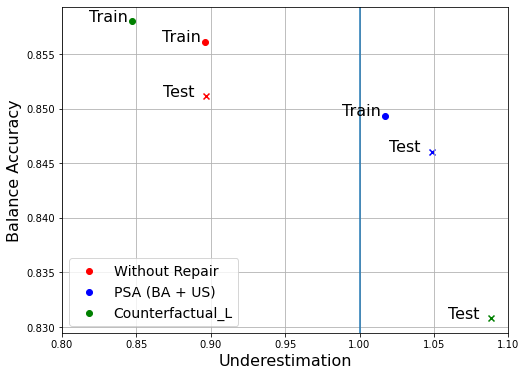

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(y=[df['Balanced Accuracy (Train)'][0]], x=[df['Underestimation (Train)'][0]],marker = 'o',color='red',label='Without Repair')
plt.scatter(y=[df['Balanced Accuracy (Train)'][1]], x=[df['Underestimation (Train)'][1]],marker = 'o',color='blue',label='PSA (BA + US)')
plt.scatter(y=[df['Balanced Accuracy (Train)'][2]], x=[df['Underestimation (Train)'][2]],marker = 'o',color='green',label='Counterfactual_L')

for idx,i in enumerate(['Train','Train','Train']):
    plt.annotate(i,(df['Underestimation (Train)'][idx]-0.029,df['Balanced Accuracy (Train)'][idx]),fontsize=16)
    
plt.scatter(y=[df['Balanced Accuracy (Test)'][0]], x=[df['Underestimation (Test)'][0]],marker = 'x',color='red')
plt.scatter(y=[df['Balanced Accuracy (Test)'][1]], x=[df['Underestimation (Test)'][1]],marker = 'x',color='blue')
plt.scatter(y=[df['Balanced Accuracy (Test)'][2]], x=[df['Underestimation (Test)'][2]],marker = 'x',color='green')

for idx,i in enumerate(['Test','Test','Test']):
    plt.annotate(i,(df['Underestimation (Test)'][idx]-0.029,df['Balanced Accuracy (Test)'][idx]),fontsize=16)
    
plt.axvline(x=1.0)
plt.xlim(0.8,1.1)
plt.ylabel("Balance Accuracy",fontsize=16)
plt.xlabel("Underestimation",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.savefig('eval.png', dpi = 300,bbox_inches = 'tight')
plt.show()

In [28]:
### negative legacy
df = {}
df['Dataset'] = ['Train','Test']
df['Disparate Impact (DI)'] = [0.236211699 ,0.23135271807]
df['Balance Accuracy'] = [0.851120523084,0.8561372339]
df = pd.DataFrame(df).set_index('Dataset')

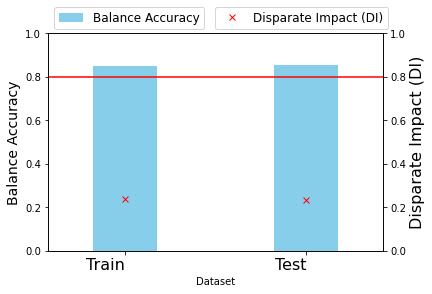

In [38]:
width = .35 # width of a bar

ax1=df['Balance Accuracy'].plot(kind='bar', width = width, 
                                 figsize=(6,4),
                                 color = ('skyblue'))
ax2=df['Disparate Impact (DI)'].plot(secondary_y=True, color = 'r',marker = 'x',linewidth=0)

ax2.set_ylim(0,1)
ax2.set_ylabel('Disparate Impact (DI)',  fontsize = 16)
ax1.set_ylabel('Balance Accuracy',  fontsize = 14)
ax1.set_xticklabels(ax1.get_xticklabels(), ha='right', fontsize = 16)
ax1.legend(bbox_to_anchor=(0,1.15), loc="upper left", ncol = 2, fontsize = 12)
ax2.legend(bbox_to_anchor=(0.48,1.15), loc="upper left", fontsize = 12)
ax1.set_ylim(0,1)
plt.axhline(y=0.8,c='r')

plt.savefig('eval_negativelegacy.png', dpi = 300,bbox_inches = 'tight')

plt.show()

In [70]:
### Counterfactual_L

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
from scipy.stats import randint as sp_randint
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import numpy as np
from random import choices
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [9]:
def add_Fx(df_p,df_n,ppc, npc):
    """
    
    Add sensitive feature {0,1} to the dataframe
    
    parameter:
    - df_p   : dataframe for Y = 1
    - df_n   : dataframe for Y = 0
    - ppc    : percentage of S = 1 in Y = 0
    - npc    : percentage of S = 1 in Y = 0
    
    output:
    - X      : 8-dim array of independent variable
    - y      : 1-dim array of target variable
    
    """
    
    
    df_p.loc[:, 'Feature_X'] = choices([0,1],cum_weights = [ppc,100], k = len(df_p))
    df_n.loc[:, 'Feature_X'] = choices([0,1],cum_weights = [npc,100], k = len(df_n))
    dall = df_p.append(df_n)   
    
#     print("Distribution of Sensitive Attribute in Y = 1: {}".format(Counter(df_p['Feature_X'])))
#     print("Distribution of Sensitive Attribute in Y = 0: {}".format(Counter(df_n['Feature_X'])))
#     print("Distribution of Y (total): {}".format(Counter(dall['Class'])))
#     print("Distribution of Sensitive Attribute in Y (total): {}".format(Counter(dall['Feature_X'])))
    y = dall.pop("admit").values
    X = dall.values
    #print("Dimension of X after adding sensitive attribute: {}".format(X.shape))
    #print("Shape of y: {}".format(y.shape))
    return X, y 

def df_subsample_pos_class(all_df, rpc = 0, subsample = True):
    
    """
    
    Add sensitive feature {0,1} to the dataframe
    
    parameter:
    - all_df : original dataframe
    - rpc    : requested positive percentage to subsample
    
    output:
    - df_p      : dataframe for Y = 1 after subsampling
    - df_n      : dataframe for Y = 0
    
    """
    
    if subsample :
        rp = rpc/100 
        df_p = all_df[all_df['admit']==1].copy()
        df_n = all_df[all_df['admit']==0].copy()
        np = len(df_p)
        nn = len(df_n)
        perc_p = np/(np+nn)
    
        if rp > perc_p:
            print('Requested positive percentage (pcpc) is too high.',perc_p)
            return df_p, df_n
    
        np_dash = rp/(1-rp)* nn
        df_p = df_p.sample(int(np_dash+0.5))
    
        #print(np,nn,'--',np_dash)
        return df_p, df_n
    else:
        df_p = all_df[all_df['admit']==1].copy()
        df_n = all_df[all_df['admit']==0].copy()
        return df_p,df_n
    
def df_count_feat_val_match(df1, f1, v1, f2, v2):
    return len (df1[(df1[f1]==int(v1)) & (df1[f2]==int(v2))])

def optimize_model(clf,param,Xtrain,Xtest,y_train,y_test,scoring,cv):
    grid = RandomizedSearchCV(clf,param,cv=cv,scoring=scoring,n_jobs=-1,n_iter=50)
    grid.fit(Xtrain,y_train)
#     print("Classifier: {}".format(clf.__class__.__name__))
#     print("Best parameter: {}".format(grid.best_params_))
#     print("Best {}: {}".format(str(scoring),grid.best_score_))
#     print("-"*30)
    y_pred = grid.predict(Xtest)
    return y_pred,grid.best_params_

## return best param
## return best score

def underestimation_score(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted outcomes
    - SA     : sensitive attributes
    
    output:
    - us_0: underestimation for S = 0
    - us_1: underestimation for S = 1
    
    """
    mydict = {}
    mydict['actual'] = y_true
    mydict['predicted'] = y_pred
    mydict['sex'] = SA
    us = pd.DataFrame(mydict)

    P_dash_FX0 = df_count_feat_val_match(us, 'predicted', 1, 'sex',0)
    P_FX0 = df_count_feat_val_match(us, 'actual', 1, 'sex',0)
    Bias_FX0 = P_dash_FX0/P_FX0
    
    if P_FX0 == 0:
        print("Divsion by zero detected!")
               
    return Bias_FX0

def evaluate_model(y_true,y_pred,SA):
    """
    
    parameter:
    - y_true : ground truth for prediction outcomes
    - y_pred : predicted labels
    - y_prob : predicted probability
    - SA     : sensitive attributes in the test data
    
    output:
    - accuracy : accuracy scores
    - rocauc   : roc auc scores
    - us_0     : underestimation score for S = 0
    - us_1     : underestimation score for S = 1
    
    """
    Counter
    accuracy = balanced_accuracy_score(y_true,y_pred)
    b = underestimation_score(y_true,y_pred,SA)

    
    ## add counter for SA
    ## add counter for class imbalance
    ## add TP TN etc
    
    return accuracy,b


    
def preprocess_data(X,y):
    """
    Numerical features are scaled using MinMaxScaler, while categorical features one-hot-encoded.
    
    parameter:
    - X    : 8-dim array of independent variable
    - y    : 1-dim array of target variable
    
    output:
    - Xtrain      : 8-dim array containing independent variable in the train test
    - Xtest       : 8-dim array containing independent variable in the test set
    - y_train     : 1-dim array of target variable in the train set
    - y_test      : 1-dim array of target variable in the test set
    
    """
    
    minority_in_Pos = 0
    
    while not minority_in_Pos:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True, stratify = y)
        temp = pd.DataFrame({'Feature_X': X_test[:,2], 'admit': y_test}, columns=['Feature_X', 'admit'])
#         print(df_count_feat_val_match(temp, 'admit', 1, 'Feature_X',0) )
        minority_in_Pos = df_count_feat_val_match(temp, 'admit', 1, 'Feature_X',0)    

    minmax = MinMaxScaler()
    xtrain_num = minmax.fit_transform(X_train[:,0:2])
    xtest_num = minmax.transform(X_test[:,0:2])
    
    Xtrain = np.hstack((xtrain_num,X_train[:,2].reshape(-1,1)))
    Xtest = np.hstack((xtest_num,X_test[:,2].reshape(-1,1)))

#     print("Shape of train data: {}".format(Xtrain.shape))
#     print("Shape of test data : {}".format(Xtest.shape))
    
    return Xtrain,Xtest,y_train,y_test

def US_scorer(clf, X_tst, y_tst):
    y_pred = clf.predict(X_tst)
    Fx_tst = [int(i) for i in X_tst[:,-1]]
    US_s = underestimation_score(y_tst,y_pred,Fx_tst)
    try:
        US = 1/(abs(1-US_s))
    except:
        US= 1/(abs((1-US_s))+0.0001)
    return US

def oversample_minority_smote_adasyn(X_N,Y_N,X_P,Y_P,ratio):

    
    from imblearn.over_sampling import SMOTE

    #oversample (SMOTE) minority for both y=0 and y=1
    X_N_smote, Y_N_smote = SMOTE(sampling_strategy='minority',n_jobs=-1,random_state=0).fit_resample(X_N, Y_N)
    X_P_smote, Y_P_smote = SMOTE(sampling_strategy='minority',n_jobs=-1,random_state=0).fit_resample(X_P, Y_P)
    X_N_smote['gender'] = Y_N_smote
    X_N_smote['admit'] = np.zeros(Y_N_smote.shape)
    X_P_smote['gender'] = Y_P_smote
    X_P_smote['admit'] = np.ones(Y_P_smote.shape)
    train_smote = pd.concat([X_N_smote,X_P_smote])

    #get xtrain and ytrain for SMOTE
    y_train_smote = train_smote['admit']
    train_smote.pop('admit')
    Xtrain_smote = train_smote
    
    return Xtrain_smote,y_train_smote

from sklearn.metrics import balanced_accuracy_score

def custom_loss_function(clf,X_tst,y_test):
    y_pred = clf.predict(X_tst)
    Fx_tst = [int(i) for i in X_tst[:,-1]]
    
    US_s = underestimation_score(y_test,y_pred,Fx_tst)
    try:
        US = 1/(abs(1-US_s))
    except:
#         print("smoothing added")
        US= 1/(abs((1-US_s))+0.0001)

    accuracy = balanced_accuracy_score(y_test,y_pred)
    
    weight_ACC = 0.5
    
    return (weight_ACC*accuracy) + ((1-weight_ACC) * US)

In [18]:
cols_name = []
for i in range(52):
    if i == 50:
        cols_name.append("gender")
    elif i == 51:
        cols_name.append("admit")
    else:
        cols_name.append(str(i))

In [19]:
cols_name

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 'gender',
 'admit']

In [28]:
y_train.values.shape

(9261,)

In [33]:
train = pd.DataFrame(np.hstack((X_train,y_train.values.reshape(-1,1))), columns=cols_name)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,gender,admit
0,1.036075,-1.002844,0.878616,-0.746236,-0.405072,-1.050878,-0.435786,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.083236,-0.155303,-0.322047,0.987991,0.862202,-0.097606,-0.232173,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2.084199,0.155483,-1.322600,0.987991,0.862202,0.685680,0.354711,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.460364,0.851413,-0.655565,0.120877,-0.405072,1.003101,-0.268104,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.350031,-0.338660,-0.322047,0.120877,0.862202,-0.263770,2.163273,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [35]:
#dataset description
NF = train[(train['gender']==0) & (train['admit']==0)]
NM = train[(train['gender']==1) & (train['admit']==0)]
PF = train[(train['gender']==0) & (train['admit']==1)]
PM = train[(train['gender']==1) & (train['admit']==1)]

print("Training set: ")
print("-"*30)
print("P(Y = 0 | S = 0) samples: {}".format(len(NF)))
print("P(Y = 0 | S = 1) samples: {}".format(len(NM)))
print("P(Y = 1 | S = 0) samples: {}".format(len(PF)))
print("P(Y = 1 | S = 1) samples: {}".format(len(PM)))



# split dataset by classes
N = pd.concat([NF.iloc[:,0:52],NM.iloc[:,0:52]])
Y_N = N['gender']
N.pop('gender')
X_N = N
P = pd.concat([PF.iloc[:,0:52],PM.iloc[:,0:52]])
Y_P = P['gender']
P.pop('gender')
X_P = P

Training set: 
------------------------------
P(Y = 0 | S = 0) samples: 2594
P(Y = 0 | S = 1) samples: 4352
P(Y = 1 | S = 0) samples: 473
P(Y = 1 | S = 1) samples: 1842


In [37]:
x_split = X_train.copy()
y_split = y_train.copy()
xtrain_tmp, xvalid, ytrain_tmp, yvalid = train_test_split(x_split, y_split, test_size=0.2, shuffle = True, random_state=40)
train_tmp = pd.DataFrame(np.hstack((xtrain_tmp,np.array(ytrain_tmp).reshape(-1,1))), columns=cols_name)
NF_tmp = train_tmp[(train_tmp['gender']==0) & (train_tmp['admit']==0)]
NM_tmp = train_tmp[(train_tmp['gender']==1) & (train_tmp['admit']==0)]
PF_tmp = train_tmp[(train_tmp['gender']==0) & (train_tmp['admit']==1)]
PM_tmp = train_tmp[(train_tmp['gender']==1) & (train_tmp['admit']==1)]

print("Temp Training set: ")
print("-"*30)
print("P(Y = 0 | S = 0) samples: {}".format(len(NF_tmp)))
print("P(Y = 0 | S = 1) samples: {}".format(len(NM_tmp)))
print("P(Y = 1 | S = 0) samples: {}".format(len(PF_tmp)))
print("P(Y = 1 | S = 1) samples: {}".format(len(PM_tmp)))

Temp Training set: 
------------------------------
P(Y = 0 | S = 0) samples: 2104
P(Y = 0 | S = 1) samples: 3472
P(Y = 1 | S = 0) samples: 375
P(Y = 1 | S = 1) samples: 1457


In [40]:
cv_scores_US = []
cv_scores_BA = []
percents = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
for percent in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]:
    to_be_sampled = int(percent/100*NF_tmp.shape[0])
    print("resampled {} from NF tmp".format(to_be_sampled))
    sampled_NF_tmp = NF_tmp.sample(n=to_be_sampled, random_state=1)
    sampled_NF_tmp['admit'] = np.ones(to_be_sampled)
    counterfactual_1 = pd.concat([sampled_NF_tmp,PF_tmp,PM_tmp,NF_tmp,NM_tmp])
    y_train_counterfactual_1 = counterfactual_1['admit']
    counterfactual_1.pop('admit')
    Xtrain_counterfactual_1 = counterfactual_1
    
    lr = LogisticRegression(solver = 'lbfgs', max_iter=10000)
    lr.fit(Xtrain_counterfactual_1, y_train_counterfactual_1)
    y_pred_3cv = lr.predict(xvalid)
    
#     y_pred_3cv,_ = optimize_model(models,params,Xtrain_counterfactual_1,xvalid,y_train_counterfactual_1,yvalid,'balanced_accuracy',10)
    accuracy_3cv,bi_3cv = evaluate_model(yvalid,y_pred_3cv,xvalid[:,-1].ravel()) 
    us = (1/(abs(1-bi_3cv)+0.000001))
    cv_scores_US.append(us)
    cv_scores_BA.append(accuracy_3cv)

print(cv_scores_US)

resampled 105 from NF tmp
resampled 210 from NF tmp
resampled 315 from NF tmp
resampled 420 from NF tmp
resampled 526 from NF tmp
resampled 631 from NF tmp
resampled 736 from NF tmp
resampled 841 from NF tmp
resampled 946 from NF tmp
resampled 1052 from NF tmp
resampled 1157 from NF tmp
resampled 1262 from NF tmp
resampled 1367 from NF tmp
resampled 1472 from NF tmp
resampled 1578 from NF tmp
resampled 1683 from NF tmp
resampled 1788 from NF tmp
resampled 1893 from NF tmp
resampled 1998 from NF tmp
resampled 2104 from NF tmp
[24.499399764705736, 5.4444148026305195, 2.7222148117485685, 1.999996000008, 1.7499969375053595, 1.399998040002744, 1.2249984993768381, 0.9799990396009415, 0.8749992343756701, 0.7596893453522803, 0.6901403687763652, 0.6202527798432126, 0.573099086761927, 0.5297294491162918, 0.48039192608623155, 0.45370349785674635, 0.42794741511420664, 0.39516113417019694, 0.3769229348521246, 0.35897423011181484]


In [41]:
to_be_sampled = int(percents[np.argmax(cv_scores_US)]/100*NF.shape[0])
print(to_be_sampled)

129


In [47]:
accuracies_3 = []
bis_3 = []
to_be_sampled = int(percents[np.argmax(cv_scores_US)]/100*NF.shape[0])
## counterfactual - 1
sampled_NF = NF.sample(n=to_be_sampled, random_state=1)
sampled_NF['admit'] = np.ones(to_be_sampled)
counterfactual_1 = pd.concat([sampled_NF,PF,PM,NF,NM])
y_train_counterfactual_1 = counterfactual_1['admit']
counterfactual_1.pop('admit')
Xtrain_counterfactual_1 = counterfactual_1
# y_pred_3,_ = optimize_model(models,params,Xtrain_counterfactual_1,Xtest,y_train_counterfactual_1,y_test,'balanced_accuracy',10)
lr = LogisticRegression(solver = 'lbfgs', max_iter=10000)
lr.fit(Xtrain_counterfactual_1, y_train_counterfactual_1)
y_pred_3 = lr.predict(X_test)
accuracy_3,bi_3 = evaluate_model(y_test,y_pred_3,X_test[:,-1].ravel()) 
accuracies_3.append(accuracy_3)


bis_3.append(bi_3)
print("accuracy:")
print(np.median(accuracies_3))
print("underestimation:")
print(np.median(bis_3)) 

accuracy:
0.8579827012128229
underestimation:
1.088235294117647


In [52]:
accuracies_3 = []
bis_3 = []
to_be_sampled = int(percents[np.argmax(cv_scores_US)]/100*NF.shape[0])
## counterfactual - 1
sampled_NF = NF.sample(n=to_be_sampled, random_state=1)
sampled_NF['admit'] = np.ones(to_be_sampled)
counterfactual_1 = pd.concat([sampled_NF,PF,PM,NF,NM])
y_train_counterfactual_1 = counterfactual_1['admit']
counterfactual_1.pop('admit')
Xtrain_counterfactual_1 = counterfactual_1
# y_pred_3,_ = optimize_model(models,params,Xtrain_counterfactual_1,Xtest,y_train_counterfactual_1,y_test,'balanced_accuracy',10)
lr = LogisticRegression(solver = 'lbfgs', max_iter=10000)
lr.fit(Xtrain_counterfactual_1, y_train_counterfactual_1)
y_pred_3 = lr.predict(Xtrain_counterfactual_1)
accuracy_3,bi_3 = evaluate_model(y_train_counterfactual_1,y_pred_3,Xtrain_counterfactual_1.values[:,-1].ravel()) 
accuracies_3.append(accuracy_3)


bis_3.append(bi_3)
print("accuracy:")
print(np.median(accuracies_3))
print("underestimation:")
print(np.median(bis_3)) 

accuracy:
0.8308285850679759
underestimation:
0.8471760797342193
